<a href="https://colab.research.google.com/github/iamviji/project/blob/master/PostMidTerm/misc/BER_BLER_PyLDPC_CommPy_ITPP_LDPC_50_100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/veeresht/CommPy.git
import sys
sys.path.append('./CommPy')

Cloning into 'CommPy'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 2107 (delta 5), reused 4 (delta 0), pack-reused 2090
Receiving objects: 100% (2107/2107), 1.42 MiB | 4.03 MiB/s, done.
Resolving deltas: 100% (1318/1318), done.


In [2]:
import commpy.channels as chan
import commpy.modulation as mod
import commpy.utilities as util
!pip install pyldpc

     |████████████████████████████████| 1.1MB 7.7MB/s 
  Created wheel for pyldpc: filename=pyldpc-0.7.9-cp36-none-any.whl size=14306 sha256=cf62d7bbde020033635631de5e38090207a691ce4c8cc7bb7c99f158ef740d9a
  Stored in directory: /root/.cache/pip/wheels/47/7a/10/e94058ba8b0b6d98bf2719226d18d3dd6056525ad7b984c068
Successfully built pyldpc


In [3]:
import pyldpc
import numpy 
import time


In [4]:
SNR_BEGIN = 0
SNR_END = 10
SNR_STEP_SIZE = 0.5
CHANEL_SIZE = 18
NUM_OF_INPUT_MESSAGE = 1000
LDPC_MAX_ITER = 100
num_parity_check = 8
num_bits_in_parity_check = 9 
input_message_length =  0 # Caculated by channel encoder and initialized later



In [84]:
plot_x_axis = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32]

In [5]:
def timer_update(i,current,time_tot,tic_incr=500):
    last = current
    current = time.time()
    t_diff = current-last
    print('SNR: {:04.3f} - Iter: {} - Last {} iterations took {:03.2f}s'.format(snr,i+1,tic_incr,t_diff))
    return time_tot + t_diff

def Snr2Sigma(snr):
  sigma = 10 ** (- snr / 20)
  return sigma

def pyldpc_encode (CodingMatrix, message):
  rng = pyldpc.utils.check_random_state(seed=None)
  d = pyldpc.utils.binaryproduct(CodingMatrix, message)
  encoded_message = (-1) ** d
  return encoded_message

def pyldpc_decode (ParityCheckMatrix, CodingMatrix, message, snr, maxiter):
  decoded_msg = pyldpc.decode(ParityCheckMatrix, message, snr, maxiter)
  out_message = pyldpc.get_message(CodingMatrix, decoded_msg)
  return out_message



In [6]:

ParityCheckMatrix, CodingMatrix = pyldpc.make_ldpc(CHANEL_SIZE, num_parity_check, num_bits_in_parity_check, systematic=True, sparse=True)
input_message_length = CodingMatrix.shape[1]
print ("input_message_size=", input_message_length, "channel_size=",CHANEL_SIZE)
print ("input_message_size=", CodingMatrix.shape[1], "channel_size=",CodingMatrix.shape[0])
input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,input_message_length))
print (input_message)

input_message_size= 9 channel_size= 18
input_message_size= 9 channel_size= 18
[[0 1 1 ... 0 1 0]
 [0 1 0 ... 1 1 0]
 [0 0 1 ... 1 1 0]
 ...
 [1 0 1 ... 0 1 1]
 [0 0 1 ... 1 0 1]
 [1 1 1 ... 0 0 1]]


In [7]:
import commpy
# Here I am using commpy based AWGN 
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_pyldpc  = numpy.array(())
ber_per_iter_pyldpc  = numpy.array(())
times_per_iter_pyldpc= numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc.encode (CodingMatrix, input_message[i], snr)
    awgn_channel_output_message = encoded_message
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)    
    diffc = abs(decoded_message-input_message[i]).sum()
    if diffc != 0 :
      total_msg_error = total_msg_error + 1
      total_bit_error = total_bit_error + diffc
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = float(total_bit_error)/(NUM_OF_INPUT_MESSAGE*input_message_length)
  print('SNR: {:04.3f}:\n -> BLER: {:03.3f} BER: {:03.3f}\n -> Total Time: {:03.2f}s'.format(snr,bler,ber,total_time))
  bler_per_iter_pyldpc=numpy.append(bler_per_iter_pyldpc ,bler)
  ber_per_iter_pyldpc=numpy.append(ber_per_iter_pyldpc ,ber)
  times_per_iter_pyldpc=numpy.append(times_per_iter_pyldpc, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 6.95s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 13.85s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 20.79s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 27.73s
SNR: 0.000:
 -> BLER: 0.659 BER: 0.146
 -> Total Time: 69.31s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 6.70s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 12.87s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 18.84s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 24.76s
SNR: 0.500:
 -> BLER: 0.564 BER: 0.124
 -> Total Time: 63.17s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 6.13s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 11.54s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 16.89s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 22.08s
SNR: 1.000:
 -> BLER: 0.494 BER: 0.109
 -> Total Time: 56.65s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 4.59s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations t

In [8]:
modem = mod.PSKModem(2)
awgn_channel = chan.SISOFlatChannel(None, (1 + 0j, 0j))

output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_pyldpc_commpy_psk_2  = numpy.array(())
ber_per_iter_pyldpc_commpy_psk_2  = numpy.array(())
times_per_iter_pyldpc_commpy_psk_2= numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    #print(encoded_message)
    encoded_message[encoded_message<0] = 0 #(convert modulation to channel encoding)
    #print(encoded_message)
    modem_output = modem.modulate (encoded_message)
    #print (modem_output)
    awgn_channel.set_SNR_dB(snr)
    awgn_channel_output_message = awgn_channel.propagate(modem_output)
    #print (awgn_channel_output_message)
    dmodem_output = modem.demodulate(awgn_channel_output_message, 'hard')
    #print (dmodem_output)
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, dmodem_output, snr, LDPC_MAX_ITER)
    diffc = abs(decoded_message-input_message[i]).sum ()
    if diffc != 0 :
      total_msg_error = total_msg_error + 1
      total_bit_error = total_bit_error + diffc
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = float(total_bit_error)/(NUM_OF_INPUT_MESSAGE*input_message_length)
  print('SNR: {:04.3f}:\n ->BLER: {:03.3f} BER: {:03.3f}\n -> Total Time: {:03.2f}s'.format(snr,bler,ber,total_time))
  bler_per_iter_pyldpc_commpy_psk_2=numpy.append(bler_per_iter_pyldpc_commpy_psk_2 ,bler)
  ber_per_iter_pyldpc_commpy_psk_2=numpy.append(ber_per_iter_pyldpc_commpy_psk_2 ,ber)
  times_per_iter_pyldpc_commpy_psk_2=numpy.append(times_per_iter_pyldpc_commpy_psk_2, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 5.61s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 12.22s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 18.49s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 25.23s
SNR: 0.000:
 ->BLER: 0.563 BER: 0.100
 -> Total Time: 61.55s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 5.88s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 11.81s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 17.67s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 23.50s
SNR: 0.500:
 ->BLER: 0.470 BER: 0.083
 -> Total Time: 58.86s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 5.41s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 10.75s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 16.01s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 21.71s
SNR: 1.000:
 ->BLER: 0.424 BER: 0.073
 -> Total Time: 53.88s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 5.07s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took

In [9]:
modem = mod.PSKModem(4) #QPSK
awgn_channel = chan.SISOFlatChannel(None, (1 + 0j, 0j))

output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_pyldpc_commpy_psk_4  = numpy.array(())
ber_per_iter_pyldpc_commpy_psk_4  = numpy.array(())
times_per_iter_pyldpc_commpy_psk_4= numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    #print(encoded_message)
    encoded_message[encoded_message<0] = 0 #(convert modulation to channel encoding)
    #print(encoded_message)
    modem_output = modem.modulate (encoded_message)
    #print (modem_output)
    awgn_channel.set_SNR_dB(snr)
    awgn_channel_output_message = awgn_channel.propagate(modem_output)
    #print (awgn_channel_output_message)
    dmodem_output = modem.demodulate(awgn_channel_output_message, 'hard')
    #print (dmodem_output)
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, dmodem_output, snr, LDPC_MAX_ITER)
    diffc = abs(decoded_message-input_message[i]).sum()
    if diffc != 0 :
      total_msg_error = total_msg_error + 1
      total_bit_error = total_bit_error + diffc
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = float(total_bit_error)/(NUM_OF_INPUT_MESSAGE*input_message_length)
  print('SNR: {:04.3f}:\n -> BLER: {:03.3f} BER: {:03.3f}\n -> Total Time: {:03.2f}s'.format(snr,bler,ber,total_time))
  bler_per_iter_pyldpc_commpy_psk_4=numpy.append(bler_per_iter_pyldpc_commpy_psk_4 ,bler)
  ber_per_iter_pyldpc_commpy_psk_4=numpy.append(ber_per_iter_pyldpc_commpy_psk_4 ,ber)
  times_per_iter_pyldpc_commpy_psk_4=numpy.append(times_per_iter_pyldpc_commpy_psk_4, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 8.00s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 15.87s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 23.77s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 31.59s
SNR: 0.000:
 -> BLER: 0.815 BER: 0.227
 -> Total Time: 79.23s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 7.57s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 15.00s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 22.62s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 30.40s
SNR: 0.500:
 -> BLER: 0.804 BER: 0.217
 -> Total Time: 75.60s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 7.66s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 14.92s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 22.40s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 30.10s
SNR: 1.000:
 -> BLER: 0.756 BER: 0.207
 -> Total Time: 75.07s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 7.23s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations t

In [10]:
num_parity_check = 5
num_bits_in_parity_check = 10
CHANEL_SIZE_50_100 = 100
ParityCheckMatrix, CodingMatrix = pyldpc.make_ldpc(CHANEL_SIZE_50_100, num_parity_check, num_bits_in_parity_check, systematic=True, sparse=True)
input_message_length_50_100 = CodingMatrix.shape[1]
print ("input_message_size=", input_message_length_50_100, "channel_size=",CHANEL_SIZE_50_100)
print ("input_message_size=", CodingMatrix.shape[1], "channel_size=",CodingMatrix.shape[0])
input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,input_message_length_50_100))
print (input_message)

input_message_size= 54 channel_size= 100
input_message_size= 54 channel_size= 100
[[1 0 0 ... 0 0 1]
 [1 0 1 ... 1 0 1]
 [1 0 1 ... 0 0 1]
 ...
 [0 1 1 ... 0 0 0]
 [1 1 0 ... 1 0 1]
 [0 0 0 ... 1 0 0]]


In [11]:
modem = mod.PSKModem(4) #QPSK
awgn_channel = chan.SISOFlatChannel(None, (1 + 0j, 0j))

output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_pyldpc_50_100_commpy_psk_4  = numpy.array(())
ber_per_iter_pyldpc_50_100_commpy_psk_4  = numpy.array(())
times_per_iter_pyldpc_50_100_commpy_psk_4= numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    #print(encoded_message)
    encoded_message[encoded_message<0] = 0 #(convert modulation to channel encoding)
    #print(encoded_message)
    modem_output = modem.modulate (encoded_message)
    #print (modem_output)
    awgn_channel.set_SNR_dB(snr)
    awgn_channel_output_message = awgn_channel.propagate(modem_output)
    #print (awgn_channel_output_message)
    dmodem_output = modem.demodulate(awgn_channel_output_message, 'hard')
    #print (dmodem_output)
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, dmodem_output, snr, LDPC_MAX_ITER)
    diffc = abs(decoded_message-input_message[i]).sum()
    if diffc != 0 :
      total_msg_error = total_msg_error + 1
      total_bit_error = total_bit_error + diffc
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = float(total_bit_error)/(NUM_OF_INPUT_MESSAGE*input_message_length_50_100)
  print('SNR: {:04.3f}:\n -> BLER: {:03.3f} BER: {:03.3f}\n -> Total Time: {:03.2f}s'.format(snr,bler, ber,total_time))
  bler_per_iter_pyldpc_50_100_commpy_psk_4=numpy.append(bler_per_iter_pyldpc_50_100_commpy_psk_4 ,bler)
  ber_per_iter_pyldpc_50_100_commpy_psk_4=numpy.append(ber_per_iter_pyldpc_50_100_commpy_psk_4 ,ber)
  times_per_iter_pyldpc_50_100_commpy_psk_4=numpy.append(times_per_iter_pyldpc_50_100_commpy_psk_4, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 33.36s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 66.71s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 100.07s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 133.45s
SNR: 0.000:
 -> BLER: 1.000 BER: 0.215
 -> Total Time: 333.59s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 33.36s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 66.66s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 99.97s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 133.28s
SNR: 0.500:
 -> BLER: 1.000 BER: 0.202
 -> Total Time: 333.27s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 33.37s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 66.61s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 100.00s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 133.39s
SNR: 1.000:
 -> BLER: 1.000 BER: 0.179
 -> Total Time: 333.37s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 33.28s
SNR: 1.500 - Iter: 500 - Last 250.0 

In [12]:
input_message_length = 9
input_message_uncoded = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,input_message_length))

modem = mod.PSKModem(2)
awgn_channel = chan.SISOFlatChannel(None, (1 + 0j, 0j))

output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_uncoded_commpy_psk_2  = numpy.array(())
ber_per_iter_uncoded_commpy_psk_2  = numpy.array(())
times_per_iter_uncoded_commpy_psk_2 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    #encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    #print(encoded_message)
    #encoded_message[encoded_message<0] = 0 #(convert modulation to channel encoding)
    #print(encoded_message)
    modem_output = modem.modulate (input_message_uncoded[i])
    #print (modem_output)
    awgn_channel.set_SNR_dB(snr)
    awgn_channel_output_message = awgn_channel.propagate(modem_output)
    #print (awgn_channel_output_message)
    decoded_message = modem.demodulate(awgn_channel_output_message, 'hard')
    #print (dmodem_output)
    #decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, dmodem_output, snr, LDPC_MAX_ITER)
    diffc = abs(decoded_message-input_message_uncoded[i]).sum()
    if diffc != 0 :
      total_msg_error = total_msg_error + 1
      total_bit_error = total_bit_error + diffc
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = float(total_bit_error)/(NUM_OF_INPUT_MESSAGE*input_message_length)
  print('SNR: {:04.3f}:\n -> BLER: {:03.3f} BER: {:03.3f}\n -> Total Time: {:03.2f}s'.format(snr,bler, ber,total_time))
  bler_per_iter_uncoded_commpy_psk_2=numpy.append(bler_per_iter_uncoded_commpy_psk_2 ,bler)
  ber_per_iter_uncoded_commpy_psk_2=numpy.append(ber_per_iter_uncoded_commpy_psk_2 ,ber)
  times_per_iter_uncoded_commpy_psk_2=numpy.append(times_per_iter_uncoded_commpy_psk_2, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.03s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.06s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.09s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.12s
SNR: 0.000:
 -> BLER: 0.510 BER: 0.079
 -> Total Time: 0.31s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.03s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.08s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.11s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.15s
SNR: 0.500:
 -> BLER: 0.471 BER: 0.067
 -> Total Time: 0.37s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.03s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.06s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.09s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.12s
SNR: 1.000:
 -> BLER: 0.407 BER: 0.055
 -> Total Time: 0.30s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.03s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.06s
SN

In [13]:
input_message_length = 50
input_message_uncoded = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,input_message_length))

modem = mod.PSKModem(2)
awgn_channel = chan.SISOFlatChannel(None, (1 + 0j, 0j))

output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_uncoded_50_commpy_psk_2  = numpy.array(())
ber_per_iter_uncoded_50_commpy_psk_2  = numpy.array(())
times_per_iter_uncoded_50_commpy_psk_2 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    #encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    #print(encoded_message)
    #encoded_message[encoded_message<0] = 0 #(convert modulation to channel encoding)
    #print(encoded_message)
    modem_output = modem.modulate (input_message_uncoded[i])
    #print (modem_output)
    awgn_channel.set_SNR_dB(snr)
    awgn_channel_output_message = awgn_channel.propagate(modem_output)
    #print (awgn_channel_output_message)
    decoded_message = modem.demodulate(awgn_channel_output_message, 'hard')
    #print (dmodem_output)
    #decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, dmodem_output, snr, LDPC_MAX_ITER)
    diffc = abs(decoded_message-input_message_uncoded[i]).sum()
    if diffc != 0 :
      total_msg_error = total_msg_error + 1
      total_bit_error = total_bit_error + diffc
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = float(total_bit_error)/(NUM_OF_INPUT_MESSAGE*input_message_length)
  print('SNR: {:04.3f}:\n -> BLER: {:03.3f} BER: {:03.3f}\n -> Total Time: {:03.2f}s'.format(snr,bler,ber,total_time))
  bler_per_iter_uncoded_50_commpy_psk_2=numpy.append(bler_per_iter_uncoded_50_commpy_psk_2 ,bler)
  ber_per_iter_uncoded_50_commpy_psk_2=numpy.append(ber_per_iter_uncoded_50_commpy_psk_2 ,ber)
  times_per_iter_uncoded_50_commpy_psk_2=numpy.append(times_per_iter_uncoded_50_commpy_psk_2, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.07s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.13s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.20s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.26s
SNR: 0.000:
 -> BLER: 0.979 BER: 0.078
 -> Total Time: 0.66s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.07s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.13s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.20s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.27s
SNR: 0.500:
 -> BLER: 0.959 BER: 0.066
 -> Total Time: 0.67s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.07s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.13s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.21s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.28s
SNR: 1.000:
 -> BLER: 0.941 BER: 0.056
 -> Total Time: 0.69s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.07s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.13s
SN

In [14]:
input_message_length = 100
input_message_uncoded = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,input_message_length))

modem = mod.PSKModem(2)
awgn_channel = chan.SISOFlatChannel(None, (1 + 0j, 0j))

output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_uncoded_100_commpy_psk_2  = numpy.array(())
ber_per_iter_uncoded_100_commpy_psk_2  = numpy.array(())
times_per_iter_uncoded_100_commpy_psk_2 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    #encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    #print(encoded_message)
    #encoded_message[encoded_message<0] = 0 #(convert modulation to channel encoding)
    #print(encoded_message)
    modem_output = modem.modulate (input_message_uncoded[i])
    #print (modem_output)
    awgn_channel.set_SNR_dB(snr)
    awgn_channel_output_message = awgn_channel.propagate(modem_output)
    #print (awgn_channel_output_message)
    decoded_message = modem.demodulate(awgn_channel_output_message, 'hard')
    #print (dmodem_output)
    #decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, dmodem_output, snr, LDPC_MAX_ITER)
    diffc = abs(decoded_message-input_message_uncoded[i]).sum()
    if diffc != 0 :
      total_msg_error = total_msg_error + 1
      total_bit_error = total_bit_error + diffc
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = float(total_bit_error)/(NUM_OF_INPUT_MESSAGE*input_message_length)
  print('SNR: {:04.3f}:\n -> BLER: {:03.3f} BER: {:03.3f}\n -> Total Time: {:03.2f}s'.format(snr,bler,ber,total_time))
  bler_per_iter_uncoded_100_commpy_psk_2=numpy.append(bler_per_iter_uncoded_100_commpy_psk_2 ,bler)
  ber_per_iter_uncoded_100_commpy_psk_2=numpy.append(ber_per_iter_uncoded_100_commpy_psk_2 ,ber)
  times_per_iter_uncoded_100_commpy_psk_2=numpy.append(times_per_iter_uncoded_100_commpy_psk_2, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.11s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.23s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.35s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.46s
SNR: 0.000:
 -> BLER: 1.000 BER: 0.079
 -> Total Time: 1.15s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.11s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.23s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.34s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.47s
SNR: 0.500:
 -> BLER: 0.999 BER: 0.065
 -> Total Time: 1.15s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.12s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.23s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.35s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.47s
SNR: 1.000:
 -> BLER: 0.996 BER: 0.057
 -> Total Time: 1.16s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.12s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.23s
SN

In [15]:
input_message_length = 10
input_message_uncoded = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,input_message_length))

modem = mod.PSKModem(4)
awgn_channel = chan.SISOFlatChannel(None, (1 + 0j, 0j))

output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_uncoded_commpy_psk_4  = numpy.array(())
ber_per_iter_uncoded_commpy_psk_4  = numpy.array(())
times_per_iter_uncoded_commpy_psk_4 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    #encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    #print(encoded_message)
    #encoded_message[encoded_message<0] = 0 #(convert modulation to channel encoding)
    #print(encoded_message)
    modem_output = modem.modulate (input_message_uncoded[i])
    #print (modem_output)
    awgn_channel.set_SNR_dB(snr)
    awgn_channel_output_message = awgn_channel.propagate(modem_output)
    #print (awgn_channel_output_message)
    decoded_message = modem.demodulate(awgn_channel_output_message, 'hard')
    #print (dmodem_output)
    #decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, dmodem_output, snr, LDPC_MAX_ITER)
    diffc = abs(decoded_message-input_message_uncoded[i]).sum()
    if diffc != 0 :
      total_msg_error = total_msg_error + 1
      total_bit_error = total_bit_error + diffc
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = float(total_bit_error)/(NUM_OF_INPUT_MESSAGE*input_message_length)
  print('SNR: {:04.3f}:\n -> BLER: {:03.3f} BER: {:03.3f}\n -> Total Time: {:03.2f}s'.format(snr,bler, ber,total_time))
  bler_per_iter_uncoded_commpy_psk_4=numpy.append(bler_per_iter_uncoded_commpy_psk_4 ,bler)
  ber_per_iter_uncoded_commpy_psk_4=numpy.append(ber_per_iter_uncoded_commpy_psk_4 ,ber)
  times_per_iter_uncoded_commpy_psk_4=numpy.append(times_per_iter_uncoded_commpy_psk_4, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.03s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.06s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.10s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.12s
SNR: 0.000:
 -> BLER: 0.820 BER: 0.209
 -> Total Time: 0.31s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.03s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.06s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.08s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.12s
SNR: 0.500:
 -> BLER: 0.790 BER: 0.198
 -> Total Time: 0.28s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.03s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.06s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.09s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.12s
SNR: 1.000:
 -> BLER: 0.768 BER: 0.181
 -> Total Time: 0.30s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.03s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.06s
SN

In [16]:
input_message_length = 50
input_message_uncoded = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,input_message_length))

modem = mod.PSKModem(4)
awgn_channel = chan.SISOFlatChannel(None, (1 + 0j, 0j))

output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_uncoded_50_commpy_psk_4  = numpy.array(())
ber_per_iter_uncoded_50_commpy_psk_4  = numpy.array(())
times_per_iter_uncoded_50_commpy_psk_4 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    #encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    #print(encoded_message)
    #encoded_message[encoded_message<0] = 0 #(convert modulation to channel encoding)
    #print(encoded_message)
    modem_output = modem.modulate (input_message_uncoded[i])
    #print (modem_output)
    awgn_channel.set_SNR_dB(snr)
    awgn_channel_output_message = awgn_channel.propagate(modem_output)
    #print (awgn_channel_output_message)
    decoded_message = modem.demodulate(awgn_channel_output_message, 'hard')
    #print (dmodem_output)
    #decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, dmodem_output, snr, LDPC_MAX_ITER)
    diffc = abs(decoded_message-input_message_uncoded[i]).sum ()
    if diffc != 0 :
      total_msg_error = total_msg_error + 1
      total_bit_error = total_bit_error + diffc
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = float(total_bit_error)/(NUM_OF_INPUT_MESSAGE*input_message_length)
  print('SNR: {:04.3f}:\n ->BLER: {:03.3f} BER: {:03.3f}\n -> Total Time: {:03.2f}s'.format(snr,bler,ber,total_time))
  bler_per_iter_uncoded_50_commpy_psk_4=numpy.append(bler_per_iter_uncoded_50_commpy_psk_4 ,bler)
  ber_per_iter_uncoded_50_commpy_psk_4=numpy.append(ber_per_iter_uncoded_50_commpy_psk_4 ,ber)
  times_per_iter_uncoded_50_commpy_psk_4=numpy.append(times_per_iter_uncoded_50_commpy_psk_4, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.05s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.10s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.16s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.21s
SNR: 0.000:
 ->BLER: 1.000 BER: 0.211
 -> Total Time: 0.52s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.05s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.11s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.18s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.23s
SNR: 0.500:
 ->BLER: 1.000 BER: 0.198
 -> Total Time: 0.57s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.05s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.11s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.16s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.21s
SNR: 1.000:
 ->BLER: 0.999 BER: 0.179
 -> Total Time: 0.52s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.05s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.11s
SNR: 

In [17]:
input_message_length = 100
input_message_uncoded = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,input_message_length))

modem = mod.PSKModem(4)
awgn_channel = chan.SISOFlatChannel(None, (1 + 0j, 0j))

output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_uncoded_100_commpy_psk_4  = numpy.array(())
ber_per_iter_uncoded_100_commpy_psk_4  = numpy.array(())
times_per_iter_uncoded_100_commpy_psk_4 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    #encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    #print(encoded_message)
    #encoded_message[encoded_message<0] = 0 #(convert modulation to channel encoding)
    #print(encoded_message)
    modem_output = modem.modulate (input_message_uncoded[i])
    #print (modem_output)
    awgn_channel.set_SNR_dB(snr)
    awgn_channel_output_message = awgn_channel.propagate(modem_output)
    #print (awgn_channel_output_message)
    decoded_message = modem.demodulate(awgn_channel_output_message, 'hard')
    #print (dmodem_output)
    #decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, dmodem_output, snr, LDPC_MAX_ITER)
    diffc = abs(decoded_message-input_message_uncoded[i]).sum ()
    if diffc != 0 :
      total_msg_error = total_msg_error + 1
      total_bit_error = total_bit_error + diffc
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = float(total_bit_error)/(NUM_OF_INPUT_MESSAGE*input_message_length)
  print('SNR: {:04.3f}:\n ->BLER: {:03.3f} BER: {:03.3f}\n -> Total Time: {:03.2f}s'.format(snr,bler,ber,total_time))
  bler_per_iter_uncoded_100_commpy_psk_4=numpy.append(bler_per_iter_uncoded_100_commpy_psk_4 ,bler)
  ber_per_iter_uncoded_100_commpy_psk_4=numpy.append(ber_per_iter_uncoded_100_commpy_psk_4 ,ber)
  times_per_iter_uncoded_100_commpy_psk_4=numpy.append(times_per_iter_uncoded_100_commpy_psk_4, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.08s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.16s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.23s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.31s
SNR: 0.000:
 ->BLER: 1.000 BER: 0.214
 -> Total Time: 0.78s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.08s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.16s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.24s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.32s
SNR: 0.500:
 ->BLER: 1.000 BER: 0.197
 -> Total Time: 0.80s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.08s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.16s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.24s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.32s
SNR: 1.000:
 ->BLER: 1.000 BER: 0.178
 -> Total Time: 0.80s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.09s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.18s
SNR: 

In [18]:
input_message_length = 100
input_message_uncoded = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,input_message_length))

modem = mod.PSKModem(4)
awgn_channel = chan.SISOFlatChannel(None, (1 + 0j, 0j))

output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_uncoded_100_commpy_psk_4  = numpy.array(())
ber_per_iter_uncoded_100_commpy_psk_4  = numpy.array(())
times_per_iter_uncoded_100_commpy_psk_4 = numpy.array(())

for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    #encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    #print(encoded_message)
    #encoded_message[encoded_message<0] = 0 #(convert modulation to channel encoding)
    #print(encoded_message)
    modem_output = modem.modulate (input_message_uncoded[i])
    #print (modem_output)
    awgn_channel.set_SNR_dB(snr)
    awgn_channel_output_message = awgn_channel.propagate(modem_output)
    #print (awgn_channel_output_message)
    decoded_message = modem.demodulate(awgn_channel_output_message, 'hard')
    #print (dmodem_output)
    #decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, dmodem_output, snr, LDPC_MAX_ITER)
    diffc = abs(decoded_message-input_message_uncoded[i]).sum ()
    if diffc != 0 :
      total_msg_error = total_msg_error + 1
      total_bit_error = total_bit_error + diffc
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = float(total_bit_error)/(NUM_OF_INPUT_MESSAGE*input_message_length)
  print('SNR: {:04.3f}:\n ->BLER: {:03.3f} BER: {:03.3f}\n -> Total Time: {:03.2f}s'.format(snr,bler,ber,total_time))
  bler_per_iter_uncoded_100_commpy_psk_4=numpy.append(bler_per_iter_uncoded_100_commpy_psk_4 ,bler)
  ber_per_iter_uncoded_100_commpy_psk_4=numpy.append(ber_per_iter_uncoded_100_commpy_psk_4 ,ber)
  times_per_iter_uncoded_100_commpy_psk_4=numpy.append(times_per_iter_uncoded_100_commpy_psk_4, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.09s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.17s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.25s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.33s
SNR: 0.000:
 ->BLER: 1.000 BER: 0.213
 -> Total Time: 0.85s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.08s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.16s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.24s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.32s
SNR: 0.500:
 ->BLER: 1.000 BER: 0.194
 -> Total Time: 0.80s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.08s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.16s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.23s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.31s
SNR: 1.000:
 ->BLER: 1.000 BER: 0.177
 -> Total Time: 0.78s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.09s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.16s
SNR: 

In [19]:
input_message_length = 9 
input_message_uncoded = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,input_message_length))

modem = mod.PSKModem(8)
awgn_channel = chan.SISOFlatChannel(None, (1 + 0j, 0j))

output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_uncoded_commpy_psk_8  = numpy.array(())
ber_per_iter_uncoded_commpy_psk_8  = numpy.array(())
times_per_iter_uncoded_commpy_psk_8 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    #encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    #print(encoded_message)
    #encoded_message[encoded_message<0] = 0 #(convert modulation to channel encoding)
    #print(encoded_message)
    modem_output = modem.modulate (input_message_uncoded[i])
    #print (modem_output)
    awgn_channel.set_SNR_dB(snr)
    awgn_channel_output_message = awgn_channel.propagate(modem_output)
    #print (awgn_channel_output_message)
    decoded_message = modem.demodulate(awgn_channel_output_message, 'hard')
    #print (dmodem_output)
    #decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, dmodem_output, snr, LDPC_MAX_ITER)
    diffc = abs(decoded_message-input_message_uncoded[i]).sum ()
    if diffc != 0 :
      total_msg_error = total_msg_error + 1
      total_bit_error = total_bit_error + diffc
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = float(total_bit_error)/(NUM_OF_INPUT_MESSAGE*input_message_length)
  print('SNR: {:04.3f}:\n ->BLER: {:03.3f} BER: {:03.3f}\n -> Total Time: {:03.2f}s'.format(snr,bler,ber,total_time))
  bler_per_iter_uncoded_commpy_psk_8=numpy.append(bler_per_iter_uncoded_commpy_psk_8 ,bler)
  ber_per_iter_uncoded_commpy_psk_8=numpy.append(ber_per_iter_uncoded_commpy_psk_8 ,ber)
  times_per_iter_uncoded_commpy_psk_8=numpy.append(times_per_iter_uncoded_commpy_psk_8, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.03s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.06s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.09s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.12s
SNR: 0.000:
 ->BLER: 0.939 BER: 0.335
 -> Total Time: 0.29s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.03s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.05s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.08s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.11s
SNR: 0.500:
 ->BLER: 0.919 BER: 0.322
 -> Total Time: 0.27s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.03s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.06s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.08s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.11s
SNR: 1.000:
 ->BLER: 0.895 BER: 0.319
 -> Total Time: 0.28s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.03s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.05s
SNR: 

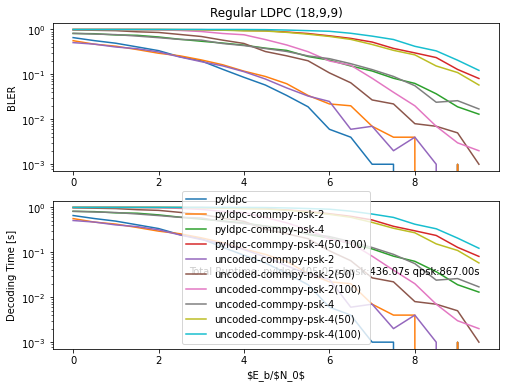

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,bler_per_iter_pyldpc,'', label="pyldpc") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_2,'', label="pyldpc-commpy-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_4,'', label="pyldpc-commpy-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_pyldpc_50_100_commpy_psk_4,'', label="pyldpc-commpy-psk-4(50,100)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_2 ,'', label="uncoded-commpy-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_50_commpy_psk_2 ,'', label="uncoded-commpy-psk-2(50)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_100_commpy_psk_2 ,'', label="uncoded-commpy-psk-2(100)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_4,'', label="uncoded-commpy-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_50_commpy_psk_4,'', label="uncoded-commpy-psk-4(50)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_100_commpy_psk_4,'', label="uncoded-commpy-psk-4(100)") # plot BER vs SNR
ax1.set_ylabel('BLER')
ax1.set_title('Regular LDPC ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))

ax2.semilogy(snrs,bler_per_iter_pyldpc,'', label="pyldpc") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_2,'', label="pyldpc-commpy-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_4,'', label="pyldpc-commpy-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_pyldpc_50_100_commpy_psk_4,'', label="pyldpc-commpy-psk-4(50,100)") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_2 ,'', label="uncoded-commpy-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_50_commpy_psk_2 ,'', label="uncoded-commpy-psk-2(50)") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_100_commpy_psk_2 ,'', label="uncoded-commpy-psk-2(100)") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_4,'', label="uncoded-commpy-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_50_commpy_psk_4,'', label="uncoded-commpy-psk-4(50)") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_100_commpy_psk_4,'', label="uncoded-commpy-psk-4(100)") # plot BER vs SNR
ax2.set_xlabel('$E_b/$N_0$')
ax2.set_ylabel('Decoding Time [s]')
ax2.annotate('Total Runtime: pyldpc:{:03.2f}s bpsk:{:03.2f}s qpsk:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
            numpy.sum(times_per_iter_pyldpc_commpy_psk_2), numpy.sum(times_per_iter_pyldpc_commpy_psk_4)),
            xy=(1, 0.35), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

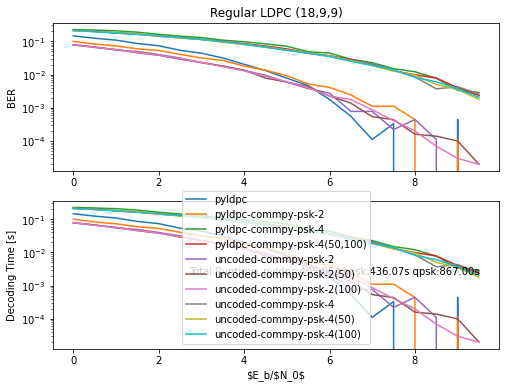

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_pyldpc,'', label="pyldpc") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_pyldpc_commpy_psk_2,'', label="pyldpc-commpy-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_pyldpc_commpy_psk_4,'', label="pyldpc-commpy-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_pyldpc_50_100_commpy_psk_4,'', label="pyldpc-commpy-psk-4(50,100)") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_uncoded_commpy_psk_2 ,'', label="uncoded-commpy-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_uncoded_50_commpy_psk_2 ,'', label="uncoded-commpy-psk-2(50)") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_uncoded_100_commpy_psk_2 ,'', label="uncoded-commpy-psk-2(100)") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_uncoded_commpy_psk_4,'', label="uncoded-commpy-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_uncoded_50_commpy_psk_4,'', label="uncoded-commpy-psk-4(50)") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_uncoded_100_commpy_psk_4,'', label="uncoded-commpy-psk-4(100)") # plot BER vs SNR
ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))

ax2.semilogy(snrs,ber_per_iter_pyldpc,'', label="pyldpc") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_pyldpc_commpy_psk_2,'', label="pyldpc-commpy-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_pyldpc_commpy_psk_4,'', label="pyldpc-commpy-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_pyldpc_50_100_commpy_psk_4,'', label="pyldpc-commpy-psk-4(50,100)") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_uncoded_commpy_psk_2 ,'', label="uncoded-commpy-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_uncoded_50_commpy_psk_2 ,'', label="uncoded-commpy-psk-2(50)") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_uncoded_100_commpy_psk_2 ,'', label="uncoded-commpy-psk-2(100)") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_uncoded_commpy_psk_4,'', label="uncoded-commpy-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_uncoded_50_commpy_psk_4,'', label="uncoded-commpy-psk-4(50)") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_uncoded_100_commpy_psk_4,'', label="uncoded-commpy-psk-4(100)") # plot BER vs SNR
ax2.set_xlabel('$E_b/$N_0$')
ax2.set_ylabel('Decoding Time [s]')
ax2.annotate('Total Runtime: pyldpc:{:03.2f}s bpsk:{:03.2f}s qpsk:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
            numpy.sum(times_per_iter_pyldpc_commpy_psk_2), numpy.sum(times_per_iter_pyldpc_commpy_psk_4)),
            xy=(1, 0.35), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

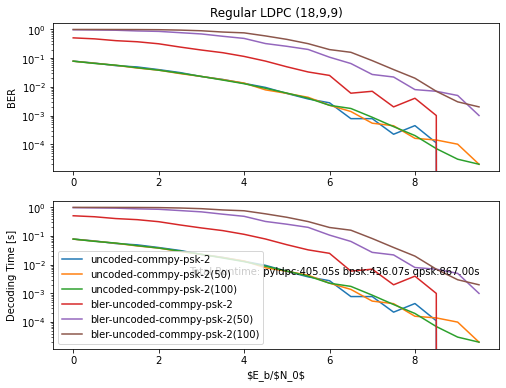

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_uncoded_commpy_psk_2 ,'', label="uncoded-commpy-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_uncoded_50_commpy_psk_2 ,'', label="uncoded-commpy-psk-2(50)") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_uncoded_100_commpy_psk_2 ,'', label="uncoded-commpy-psk-2(100)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_2 ,'', label="bler-uncoded-commpy-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_50_commpy_psk_2 ,'', label="bler-uncoded-commpy-psk-2(50)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_100_commpy_psk_2 ,'', label="bler-uncoded-commpy-psk-2(100)") # plot BER vs SNR

ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))

ax2.semilogy(snrs,ber_per_iter_uncoded_commpy_psk_2 ,'', label="uncoded-commpy-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_uncoded_50_commpy_psk_2 ,'', label="uncoded-commpy-psk-2(50)") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_uncoded_100_commpy_psk_2 ,'', label="uncoded-commpy-psk-2(100)") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_2 ,'', label="bler-uncoded-commpy-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_50_commpy_psk_2 ,'', label="bler-uncoded-commpy-psk-2(50)") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_100_commpy_psk_2 ,'', label="bler-uncoded-commpy-psk-2(100)") # plot BER vs SNR
ax2.set_xlabel('$E_b/$N_0$')
ax2.set_ylabel('Decoding Time [s]')
ax2.annotate('Total Runtime: pyldpc:{:03.2f}s bpsk:{:03.2f}s qpsk:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
            numpy.sum(times_per_iter_pyldpc_commpy_psk_2), numpy.sum(times_per_iter_pyldpc_commpy_psk_4)),
            xy=(1, 0.35), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

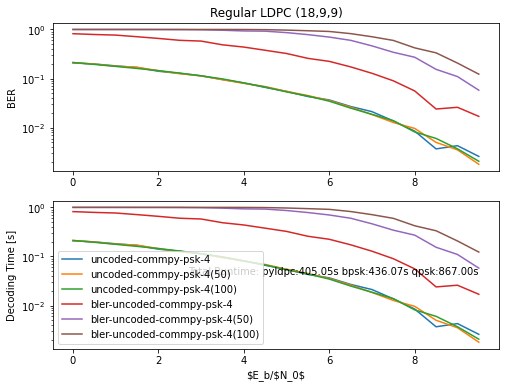

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_uncoded_commpy_psk_4,'', label="uncoded-commpy-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_uncoded_50_commpy_psk_4,'', label="uncoded-commpy-psk-4(50)") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_uncoded_100_commpy_psk_4,'', label="uncoded-commpy-psk-4(100)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_4,'', label="bler-uncoded-commpy-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_50_commpy_psk_4,'', label="bler-uncoded-commpy-psk-4(50)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_100_commpy_psk_4,'', label="bler-uncoded-commpy-psk-4(100)") # plot BER vs SNR

ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))

ax2.semilogy(snrs,ber_per_iter_uncoded_commpy_psk_4,'', label="uncoded-commpy-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_uncoded_50_commpy_psk_4,'', label="uncoded-commpy-psk-4(50)") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_uncoded_100_commpy_psk_4,'', label="uncoded-commpy-psk-4(100)") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_4,'', label="bler-uncoded-commpy-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_50_commpy_psk_4,'', label="bler-uncoded-commpy-psk-4(50)") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_100_commpy_psk_4,'', label="bler-uncoded-commpy-psk-4(100)") # plot BER vs SNR
ax2.set_xlabel('$E_b/$N_0$')
ax2.set_ylabel('Decoding Time [s]')
ax2.annotate('Total Runtime: pyldpc:{:03.2f}s bpsk:{:03.2f}s qpsk:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
            numpy.sum(times_per_iter_pyldpc_commpy_psk_2), numpy.sum(times_per_iter_pyldpc_commpy_psk_4)),
            xy=(1, 0.35), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

In [24]:
!sudo apt-get install autoconf
!sudo apt-get install libtool
!sudo apt-get install liblapack-dev libblas-dev libfftw3-dev
!rm -rf itpp
!git clone https://github.com/iamviji/itpp.git # original one had compilation issue, did minor signle line change after forking
!ls;cd itpp;ls;mkdir -p build1 build2; cd build1 ; cmake cmake ..;make ;make install
!rm -rf py-itpp
!git clone https://github.com/iamviji/py-itpp.git
!pip3 install pybind11
!cd py-itpp;./install_prerequisites_python3.sh;make install;pip3 install -e .  
!cd py-itpp; ls ; pip3 install -e .  
!cat py-itpp/setup.py
import sys
!cp -rf py-itpp/lib/itpp py-itpp/lib/pyitpp # import itpp is not working, after this hack i started to work
sys.path.append('./py-itpp/lib')
#!pip install gwpy &> /dev/null

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  automake autotools-dev libsigsegv2 m4
Suggested packages:
  autoconf-archive gnu-standards autoconf-doc libtool gettext m4-doc
The following NEW packages will be installed:
  autoconf automake autotools-dev libsigsegv2 m4
0 upgraded, 5 newly installed, 0 to remove and 14 not upgraded.
Need to get 1,082 kB of archives.
After this operation, 3,994 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libsigsegv2 amd64 2.12-1 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 m4 amd64 1.4.18-1 [197 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 autoconf all 2.69-11 [322 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/main amd64 autotools-dev all 20180224.1 [39.6 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic/main amd64 automake all 1:1.15.1-3ubuntu2 [509 kB]
Fet

In [25]:
import pyitpp as itpp
from matplotlib import pyplot as plt

In [26]:
def cout_one_in_itpp_vec (one):
  count = 0
  for i in range (0, one.length()):
    if (ord(one[i].value()) == 1):
      count = count + 1
  return count

In [27]:
input_message_length = nrof_bits = 9
modulator = itpp.comm.PSK(2)
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_uncoded_itpp_psk_2  = numpy.array(())
ber_per_iter_uncoded_itpp_psk_2  = numpy.array(())
times_per_iter_uncoded_itpp_psk_2 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, .5):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    tx_signal = modulator.modulate_bits(source_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    diffc = cout_one_in_itpp_vec (demodulated_bits -  source_bits)
    #if abs(demodulated_bits != source_bits):
    if diffc != 0: 
      total_msg_error = total_msg_error + 1
      total_bit_error = total_bit_error + diffc
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    #b = itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0)
    #print (b)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = float(total_bit_error)/(NUM_OF_INPUT_MESSAGE*input_message_length)
  print('SNR: {:04.3f}:\n -> BLER: {:03.3f} BER: {:03.3f}\n -> Total Time: {:03.2f}s'.format(snr,bler,ber,total_time))
  bler_per_iter_uncoded_itpp_psk_2=numpy.append(bler_per_iter_uncoded_itpp_psk_2 ,bler)
  ber_per_iter_uncoded_itpp_psk_2=numpy.append(ber_per_iter_uncoded_itpp_psk_2 ,ber)
  times_per_iter_uncoded_itpp_psk_2=numpy.append(times_per_iter_uncoded_itpp_psk_2, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.03s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.04s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.04s
SNR: 0.000:
 -> BLER: 0.518 BER: 0.079
 -> Total Time: 0.12s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.02s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.03s
SNR: 0.500:
 -> BLER: 0.478 BER: 0.067
 -> Total Time: 0.08s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.02s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.03s
SNR: 1.000:
 -> BLER: 0.415 BER: 0.058
 -> Total Time: 0.08s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.02s
SN

In [28]:
input_message_length = nrof_bits = 9
modulator = itpp.comm.BPSK()
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_uncoded_itpp_bpsk  = numpy.array(())
ber_per_iter_uncoded_itpp_bpsk  = numpy.array(())
times_per_iter_uncoded_itpp_bpsk = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    tx_signal = modulator.modulate_bits(source_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    diffc = cout_one_in_itpp_vec (demodulated_bits -  source_bits)
    #if abs(demodulated_bits != source_bits):
    if diffc != 0: 
      total_msg_error = total_msg_error + 1
      total_bit_error = total_bit_error + diffc
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    #b = itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0)
    #print (b)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = float(total_bit_error)/(NUM_OF_INPUT_MESSAGE*input_message_length)
  print('SNR: {:04.3f}:\n -> BLER: {:03.3f} BER: {:03.3f}\n -> Total Time: {:03.2f}s'.format(snr,bler,ber,total_time))
  bler_per_iter_uncoded_itpp_bpsk=numpy.append(bler_per_iter_uncoded_itpp_bpsk ,bler)
  ber_per_iter_uncoded_itpp_bpsk=numpy.append(ber_per_iter_uncoded_itpp_bpsk ,ber)
  times_per_iter_uncoded_itpp_bpsk=numpy.append(times_per_iter_uncoded_itpp_bpsk, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.02s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.03s
SNR: 0.000:
 -> BLER: 0.774 BER: 0.158
 -> Total Time: 0.08s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.02s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.03s
SNR: 0.500:
 -> BLER: 0.769 BER: 0.140
 -> Total Time: 0.08s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.02s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.03s
SNR: 1.000:
 -> BLER: 0.731 BER: 0.130
 -> Total Time: 0.08s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.01s
SN

In [29]:
input_message_length = nrof_bits = 10
modulator = itpp.comm.PSK(4)
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_uncoded_itpp_psk_4  = numpy.array(())
ber_per_iter_uncoded_itpp_psk_4  = numpy.array(())
times_per_iter_uncoded_itpp_psk_4 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    tx_signal = modulator.modulate_bits(source_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    diffc = cout_one_in_itpp_vec (demodulated_bits -  source_bits)
    #if abs(demodulated_bits != source_bits):
    if diffc != 0: 
      total_msg_error = total_msg_error + 1
      total_bit_error = total_bit_error + diffc
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    #b = itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0)
    #print (b)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = float(total_bit_error)/(NUM_OF_INPUT_MESSAGE*input_message_length)
  print('SNR: {:04.3f}:\n -> BLER: {:03.3f} BER: {:03.3f}\n -> Total Time: {:03.2f}s'.format(snr,bler,ber,total_time))
  bler_per_iter_uncoded_itpp_psk_4=numpy.append(bler_per_iter_uncoded_itpp_psk_4 ,bler)
  ber_per_iter_uncoded_itpp_psk_4=numpy.append(ber_per_iter_uncoded_itpp_psk_4 ,ber)
  times_per_iter_uncoded_itpp_psk_4=numpy.append(times_per_iter_uncoded_itpp_psk_4, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.02s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.03s
SNR: 0.000:
 -> BLER: 0.814 BER: 0.156
 -> Total Time: 0.07s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.02s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.03s
SNR: 0.500:
 -> BLER: 0.767 BER: 0.142
 -> Total Time: 0.07s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.02s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.03s
SNR: 1.000:
 -> BLER: 0.729 BER: 0.125
 -> Total Time: 0.08s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.01s
SN

In [30]:
input_message_length = nrof_bits = 100
modulator = itpp.comm.PSK(4)
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_uncoded_100_itpp_psk_4  = numpy.array(())
ber_per_iter_uncoded_100_itpp_psk_4  = numpy.array(())
times_per_iter_uncoded_100_itpp_psk_4 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    tx_signal = modulator.modulate_bits(source_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    diffc = cout_one_in_itpp_vec (demodulated_bits -  source_bits)
    #if abs(demodulated_bits != source_bits):
    if diffc != 0: 
      total_msg_error = total_msg_error + 1
      total_bit_error = total_bit_error + diffc
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    #b = itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0)
    #print (b)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = float(total_bit_error)/(NUM_OF_INPUT_MESSAGE*input_message_length)
  print('SNR: {:04.3f}:\n -> BLER: {:03.3f} BER: {:03.3f}\n -> Total Time: {:03.2f}s'.format(snr,bler,ber,total_time))
  bler_per_iter_uncoded_100_itpp_psk_4=numpy.append(bler_per_iter_uncoded_100_itpp_psk_4 ,bler)
  ber_per_iter_uncoded_100_itpp_psk_4=numpy.append(ber_per_iter_uncoded_100_itpp_psk_4 ,ber)
  times_per_iter_uncoded_100_itpp_psk_4=numpy.append(times_per_iter_uncoded_100_itpp_psk_4, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.06s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.10s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.14s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.19s
SNR: 0.000:
 -> BLER: 1.000 BER: 0.160
 -> Total Time: 0.48s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.04s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.08s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.13s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.18s
SNR: 0.500:
 -> BLER: 1.000 BER: 0.144
 -> Total Time: 0.43s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.06s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.10s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.15s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.19s
SNR: 1.000:
 -> BLER: 1.000 BER: 0.133
 -> Total Time: 0.50s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.04s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.09s
SN

In [31]:
input_message_length = nrof_bits = 50
modulator = itpp.comm.PSK(4)
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_uncoded_50_itpp_psk_4  = numpy.array(())
ber_per_iter_uncoded_50_itpp_psk_4  = numpy.array(())
times_per_iter_uncoded_50_itpp_psk_4 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    tx_signal = modulator.modulate_bits(source_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    diffc = cout_one_in_itpp_vec (demodulated_bits -  source_bits)
    #if abs(demodulated_bits != source_bits):
    if diffc != 0: 
      total_msg_error = total_msg_error + 1
      total_bit_error = total_bit_error + diffc
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    #b = itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0)
    #print (b)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = float(total_bit_error)/(NUM_OF_INPUT_MESSAGE*input_message_length)
  print('SNR: {:04.3f}:\n -> BLER: {:03.3f} BER: {:03.3f}\n -> Total Time: {:03.2f}s'.format(snr,bler,ber,total_time))
  bler_per_iter_uncoded_50_itpp_psk_4=numpy.append(bler_per_iter_uncoded_50_itpp_psk_4 ,bler)
  ber_per_iter_uncoded_50_itpp_psk_4=numpy.append(ber_per_iter_uncoded_50_itpp_psk_4 ,ber)
  times_per_iter_uncoded_50_itpp_psk_4=numpy.append(times_per_iter_uncoded_50_itpp_psk_4, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.02s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.05s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.08s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.10s
SNR: 0.000:
 -> BLER: 1.000 BER: 0.158
 -> Total Time: 0.25s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.03s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.05s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.07s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.10s
SNR: 0.500:
 -> BLER: 0.999 BER: 0.146
 -> Total Time: 0.24s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.02s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.05s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.07s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.10s
SNR: 1.000:
 -> BLER: 1.000 BER: 0.132
 -> Total Time: 0.25s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.03s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.05s
SN

In [32]:
input_message_length = nrof_bits = 50
modulator = itpp.comm.PSK(2)
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_uncoded_50_itpp_psk_2  = numpy.array(())
ber_per_iter_uncoded_50_itpp_psk_2  = numpy.array(())
times_per_iter_uncoded_50_itpp_psk_2 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    tx_signal = modulator.modulate_bits(source_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    diffc = cout_one_in_itpp_vec (demodulated_bits -  source_bits)
    #if abs(demodulated_bits != source_bits):
    if diffc != 0: 
      total_msg_error = total_msg_error + 1
      total_bit_error = total_bit_error + diffc
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    #b = itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0)
    #print (b)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = float(total_bit_error)/(NUM_OF_INPUT_MESSAGE*input_message_length)
  print('SNR: {:04.3f}:\n -> BLER: {:03.3f} BER: {:03.3f}\n -> Total Time: {:03.2f}s'.format(snr,bler,ber,total_time))
  bler_per_iter_uncoded_50_itpp_psk_2=numpy.append(bler_per_iter_uncoded_50_itpp_psk_2 ,bler)
  ber_per_iter_uncoded_50_itpp_psk_2=numpy.append(ber_per_iter_uncoded_50_itpp_psk_2 ,ber)
  times_per_iter_uncoded_50_itpp_psk_2=numpy.append(times_per_iter_uncoded_50_itpp_psk_2, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.03s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.06s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.08s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.11s
SNR: 0.000:
 -> BLER: 0.978 BER: 0.080
 -> Total Time: 0.27s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.03s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.06s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.08s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.11s
SNR: 0.500:
 -> BLER: 0.964 BER: 0.068
 -> Total Time: 0.27s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.03s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.05s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.08s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.11s
SNR: 1.000:
 -> BLER: 0.941 BER: 0.056
 -> Total Time: 0.26s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.03s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.06s
SN

In [33]:
input_message_length = nrof_bits = 100
modulator = itpp.comm.PSK(2)
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_uncoded_100_itpp_psk_2  = numpy.array(())
ber_per_iter_uncoded_100_itpp_psk_2  = numpy.array(())
times_per_iter_uncoded_100_itpp_psk_2 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    tx_signal = modulator.modulate_bits(source_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    diffc = cout_one_in_itpp_vec (demodulated_bits -  source_bits)
    #if abs(demodulated_bits != source_bits):
    if diffc != 0: 
      total_msg_error = total_msg_error + 1
      total_bit_error = total_bit_error + diffc
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    #b = itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0)
    #print (b)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = float(total_bit_error)/(NUM_OF_INPUT_MESSAGE*input_message_length)
  print('SNR: {:04.3f}:\n -> BLER: {:03.3f} BER: {:03.3f}\n -> Total Time: {:03.2f}s'.format(snr,bler,ber,total_time))
  bler_per_iter_uncoded_100_itpp_psk_2=numpy.append(bler_per_iter_uncoded_100_itpp_psk_2 ,bler)
  ber_per_iter_uncoded_100_itpp_psk_2=numpy.append(ber_per_iter_uncoded_100_itpp_psk_2 ,ber)
  times_per_iter_uncoded_100_itpp_psk_2=numpy.append(times_per_iter_uncoded_100_itpp_psk_2, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.05s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.09s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.14s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.19s
SNR: 0.000:
 -> BLER: 0.999 BER: 0.079
 -> Total Time: 0.47s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.05s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.09s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.14s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.20s
SNR: 0.500:
 -> BLER: 0.999 BER: 0.068
 -> Total Time: 0.48s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.05s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.09s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.14s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.19s
SNR: 1.000:
 -> BLER: 0.997 BER: 0.057
 -> Total Time: 0.47s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.05s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.09s
SN

In [34]:
print (bler_per_iter_uncoded_100_itpp_psk_4)
print (bler_per_iter_uncoded_50_itpp_psk_2)
print (bler_per_iter_uncoded_100_itpp_psk_2)
print (ber_per_iter_uncoded_100_itpp_psk_4)
print (ber_per_iter_uncoded_50_itpp_psk_2)
print (ber_per_iter_uncoded_100_itpp_psk_2)

[1.    1.    1.    1.    1.    1.    1.    0.998 0.999 0.992 0.986 0.955
 0.904 0.834 0.69  0.606 0.464 0.305 0.209 0.138]
[0.978 0.964 0.941 0.908 0.85  0.753 0.697 0.59  0.484 0.36  0.276 0.178
 0.115 0.064 0.047 0.019 0.006 0.002 0.001 0.   ]
[0.999 0.999 0.997 0.992 0.976 0.945 0.904 0.824 0.703 0.609 0.429 0.329
 0.225 0.131 0.079 0.042 0.013 0.005 0.003 0.   ]
[0.15965 0.14397 0.13328 0.11527 0.10492 0.09096 0.07876 0.06758 0.0574
 0.04708 0.03793 0.03001 0.02311 0.01739 0.01257 0.00896 0.00626 0.00369
 0.00229 0.00153]
[7.972e-02 6.822e-02 5.634e-02 4.596e-02 3.966e-02 2.886e-02 2.342e-02
 1.748e-02 1.260e-02 8.960e-03 6.480e-03 3.720e-03 2.480e-03 1.320e-03
 9.400e-04 3.800e-04 1.200e-04 4.000e-05 2.000e-05 0.000e+00]
[7.863e-02 6.768e-02 5.683e-02 4.818e-02 3.725e-02 2.978e-02 2.401e-02
 1.706e-02 1.257e-02 9.310e-03 5.710e-03 3.890e-03 2.590e-03 1.410e-03
 8.300e-04 4.300e-04 1.300e-04 5.000e-05 3.000e-05 0.000e+00]


In [35]:
input_message_length = nrof_bits = 9
modulator = itpp.comm.PSK(8)
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_uncoded_itpp_psk_8  = numpy.array(())
ber_per_iter_uncoded_itpp_psk_8  = numpy.array(())
times_per_iter_uncoded_itpp_psk_8 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    tx_signal = modulator.modulate_bits(source_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    diffc = cout_one_in_itpp_vec (demodulated_bits -  source_bits)
    #if abs(demodulated_bits != source_bits):
    if diffc != 0: 
      total_msg_error = total_msg_error + 1
      total_bit_error = total_bit_error + diffc
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    #b = itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0)
    #print (b)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = float(total_bit_error)/(NUM_OF_INPUT_MESSAGE*input_message_length)
  print('SNR: {:04.3f}:\n -> BLER: {:03.3f} BER: {:03.3f}\n -> Total Time: {:03.2f}s'.format(snr,bler,ber,total_time))
  bler_per_iter_uncoded_itpp_psk_8=numpy.append(bler_per_iter_uncoded_itpp_psk_8 ,bler)
  ber_per_iter_uncoded_itpp_psk_8=numpy.append(ber_per_iter_uncoded_itpp_psk_8 ,ber)
  times_per_iter_uncoded_itpp_psk_8=numpy.append(bler_per_iter_uncoded_itpp_psk_8, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.02s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.03s
SNR: 0.000:
 -> BLER: 0.921 BER: 0.246
 -> Total Time: 0.07s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.03s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.03s
SNR: 0.500:
 -> BLER: 0.917 BER: 0.234
 -> Total Time: 0.08s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.02s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.03s
SNR: 1.000:
 -> BLER: 0.912 BER: 0.215
 -> Total Time: 0.07s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.01s
SN

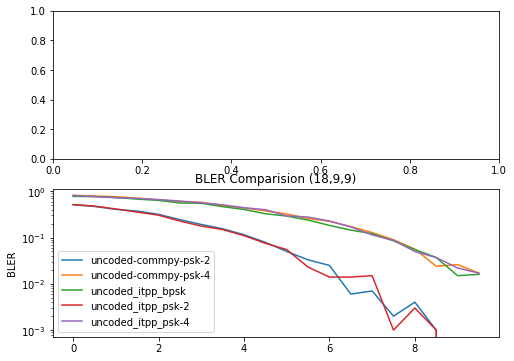

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax2.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_2 ,'', label="uncoded-commpy-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_4,'', label="uncoded-commpy-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_itpp_bpsk,'', label="uncoded_itpp_bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_2,'', label="uncoded_itpp_psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_4,'', label="uncoded_itpp_psk-4") # plot BER vs SNR
ax2.set_ylabel('BLER')
ax2.set_title('BLER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))

plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

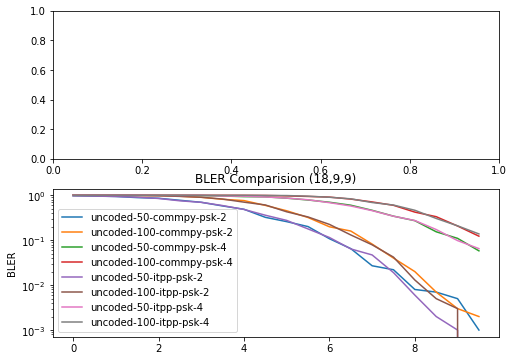

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax2.semilogy(snrs,bler_per_iter_uncoded_50_commpy_psk_2 ,'', label="uncoded-50-commpy-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_100_commpy_psk_2 ,'', label="uncoded-100-commpy-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_50_commpy_psk_4 ,'', label="uncoded-50-commpy-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_100_commpy_psk_4 ,'', label="uncoded-100-commpy-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_50_itpp_psk_2,'', label="uncoded-50-itpp-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_100_itpp_psk_2 ,'', label="uncoded-100-itpp-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_50_itpp_psk_4 ,'', label="uncoded-50-itpp-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_100_itpp_psk_4 ,'', label="uncoded-100-itpp-psk-4") # plot BER vs SNR

ax2.set_ylabel('BLER')
ax2.set_title('BLER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))

plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

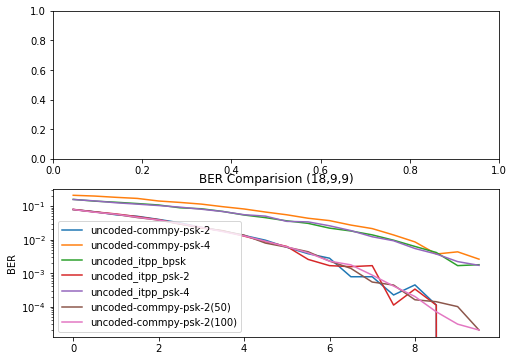

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax2.semilogy(snrs,ber_per_iter_uncoded_commpy_psk_2 ,'', label="uncoded-commpy-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_uncoded_commpy_psk_4,'', label="uncoded-commpy-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_uncoded_itpp_bpsk,'', label="uncoded_itpp_bpsk") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_uncoded_itpp_psk_2,'', label="uncoded_itpp_psk-2") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_uncoded_itpp_psk_4,'', label="uncoded_itpp_psk-4") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_uncoded_50_commpy_psk_2 ,'', label="uncoded-commpy-psk-2(50)")
ax2.semilogy(snrs,ber_per_iter_uncoded_100_commpy_psk_2 ,'', label="uncoded-commpy-psk-2(100)")
ax2.set_ylabel('BER')
ax2.set_title('BER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))

plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

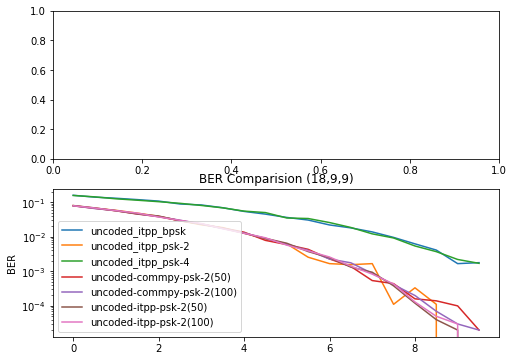

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax2.semilogy(snrs,ber_per_iter_uncoded_itpp_bpsk,'', label="uncoded_itpp_bpsk") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_uncoded_itpp_psk_2,'', label="uncoded_itpp_psk-2") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_uncoded_itpp_psk_4,'', label="uncoded_itpp_psk-4") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_uncoded_50_commpy_psk_2 ,'', label="uncoded-commpy-psk-2(50)")
ax2.semilogy(snrs,ber_per_iter_uncoded_100_commpy_psk_2 ,'', label="uncoded-commpy-psk-2(100)")
ax2.semilogy(snrs,ber_per_iter_uncoded_50_itpp_psk_2 ,'', label="uncoded-itpp-psk-2(50)")
ax2.semilogy(snrs,ber_per_iter_uncoded_100_itpp_psk_2 ,'', label="uncoded-itpp-psk-2(100)")
ax2.set_ylabel('BER')
ax2.set_title('BER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))

plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

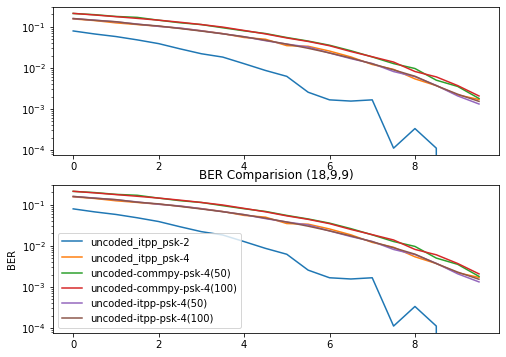

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))

ax1.semilogy(snrs,ber_per_iter_uncoded_itpp_psk_2,'', label="uncoded_itpp_psk-2") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_uncoded_itpp_psk_4,'', label="uncoded_itpp_psk-4") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_uncoded_50_commpy_psk_4 ,'', label="uncoded-commpy-psk-4(50)")
ax1.semilogy(snrs,ber_per_iter_uncoded_100_commpy_psk_4 ,'', label="uncoded-commpy-psk-4(100)")
ax1.semilogy(snrs,ber_per_iter_uncoded_50_itpp_psk_4 ,'', label="uncoded-itpp-psk-4(50)")
ax1.semilogy(snrs,ber_per_iter_uncoded_100_itpp_psk_4 ,'', label="uncoded-itpp-psk-4(100)")


ax2.semilogy(snrs,ber_per_iter_uncoded_itpp_psk_2,'', label="uncoded_itpp_psk-2") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_uncoded_itpp_psk_4,'', label="uncoded_itpp_psk-4") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_uncoded_50_commpy_psk_4 ,'', label="uncoded-commpy-psk-4(50)")
ax2.semilogy(snrs,ber_per_iter_uncoded_100_commpy_psk_4 ,'', label="uncoded-commpy-psk-4(100)")
ax2.semilogy(snrs,ber_per_iter_uncoded_50_itpp_psk_4 ,'', label="uncoded-itpp-psk-4(50)")
ax2.semilogy(snrs,ber_per_iter_uncoded_100_itpp_psk_4 ,'', label="uncoded-itpp-psk-4(100)")

ax2.set_ylabel('BER')
ax2.set_title('BER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))

plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

In [41]:
input_message_length = nrof_bits = 8 #Hamming(7,4,3) But x2
hamm = itpp.comm.Hamming_Code(3)
modulator = itpp.comm.BPSK()
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_ham_itpp_bpsk  = numpy.array(())
ber_per_iter_ham_itpp_bpsk  = numpy.array(())
times_per_iter_ham_itpp_bpsk = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    encoded_bits = hamm.encode(source_bits)
    tx_signal = modulator.modulate_bits(encoded_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    decoded_bits = hamm.decode(demodulated_bits) 
    #print (source_bits)
    #print (decoded_bits)
    diffc = cout_one_in_itpp_vec (decoded_bits -  source_bits)
    #if abs(demodulated_bits != source_bits):
    if diffc != 0: 
      total_msg_error = total_msg_error + 1
      total_bit_error = total_bit_error + diffc
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    #b = itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0)
    #print (b)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = float(total_bit_error)/(NUM_OF_INPUT_MESSAGE*input_message_length)
  print('SNR: {:04.3f}:\n -> BLER: {:03.3f} BER: {:03.3f}\n -> Total Time: {:03.2f}s'.format(snr,bler, ber,total_time))
  bler_per_iter_ham_itpp_bpsk=numpy.append(bler_per_iter_ham_itpp_bpsk ,bler)
  ber_per_iter_ham_itpp_bpsk=numpy.append(ber_per_iter_ham_itpp_bpsk ,ber)
  times_per_iter_ham_itpp_bpsk=numpy.append(times_per_iter_ham_itpp_bpsk, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.03s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.04s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.05s
SNR: 0.000:
 -> BLER: 0.537 BER: 0.143
 -> Total Time: 0.13s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.03s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.04s
SNR: 0.500:
 -> BLER: 0.402 BER: 0.106
 -> Total Time: 0.10s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.03s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.04s
SNR: 1.000:
 -> BLER: 0.397 BER: 0.103
 -> Total Time: 0.10s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.02s
SN

In [42]:
input_message_length = nrof_bits = 8 #Hamming(7,4,3) But x2
hamm = itpp.comm.Hamming_Code(3)
modulator = itpp.comm.PSK(2)
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_ham_itpp_psk_2  = numpy.array(())
ber_per_iter_ham_itpp_psk_2  = numpy.array(())
times_per_iter_ham_itpp_psk_2 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    encoded_bits = hamm.encode(source_bits)
    tx_signal = modulator.modulate_bits(encoded_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    decoded_bits = hamm.decode(demodulated_bits) 
    #print (source_bits)
    #print (decoded_bits)
    diffc = cout_one_in_itpp_vec (decoded_bits -  source_bits)
    #if abs(demodulated_bits != source_bits):
    if diffc != 0: 
      total_msg_error = total_msg_error + 1
      total_bit_error = total_bit_error + diffc
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    #b = itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0)
    #print (b)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = float(total_bit_error)/(NUM_OF_INPUT_MESSAGE*input_message_length)
  print('SNR: {:04.3f}:\n -> BLER: {:03.3f} BER: {:03.3f}\n -> Total Time: {:03.2f}s'.format(snr,bler, ber,total_time))
  bler_per_iter_ham_itpp_psk_2=numpy.append(bler_per_iter_ham_itpp_psk_2 ,bler)
  ber_per_iter_ham_itpp_psk_2=numpy.append(ber_per_iter_ham_itpp_psk_2 ,ber)
  times_per_iter_ham_itpp_psk_2=numpy.append(times_per_iter_ham_itpp_psk_2, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.03s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.05s
SNR: 0.000:
 -> BLER: 0.177 BER: 0.043
 -> Total Time: 0.12s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.04s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.05s
SNR: 0.500:
 -> BLER: 0.138 BER: 0.031
 -> Total Time: 0.12s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.03s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.04s
SNR: 1.000:
 -> BLER: 0.095 BER: 0.022
 -> Total Time: 0.11s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.02s
SN

In [43]:
input_message_length = nrof_bits = 8 #Hamming(7,4,3) But x2
hamm = itpp.comm.Hamming_Code(3)
modulator = itpp.comm.PSK(4)
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_ham_itpp_psk_4  = numpy.array(())
ber_per_iter_ham_itpp_psk_4  = numpy.array(())
times_per_iter_ham_itpp_psk_4 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    #print ("x")
    #print (source_bits)
    encoded_bits = hamm.encode(source_bits)
    #print (encoded_bits)
    tx_signal = modulator.modulate_bits(encoded_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    #print (demodulated_bits)
    decoded_bits = hamm.decode(demodulated_bits) 
    #print (decoded_bits)
    diffc = cout_one_in_itpp_vec (decoded_bits -  source_bits)
    #if abs(demodulated_bits != source_bits):
    if diffc != 0: 
      total_msg_error = total_msg_error + 1
      total_bit_error = total_bit_error + diffc
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    #b = itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0)
    #print (b)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = float(total_bit_error)/(NUM_OF_INPUT_MESSAGE*input_message_length)
  print('SNR: {:04.3f}:\n -> BLER: {:03.3f} BER: {:03.3f}\n -> Total Time: {:03.2f}s'.format(snr,bler, ber,total_time))
  bler_per_iter_ham_itpp_psk_4=numpy.append(bler_per_iter_ham_itpp_psk_4 ,bler)
  ber_per_iter_ham_itpp_psk_4=numpy.append(ber_per_iter_ham_itpp_psk_4 ,ber)
  times_per_iter_ham_itpp_psk_4=numpy.append(times_per_iter_ham_itpp_psk_4, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.03s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.05s
SNR: 0.000:
 -> BLER: 0.532 BER: 0.141
 -> Total Time: 0.11s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.03s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.04s
SNR: 0.500:
 -> BLER: 0.466 BER: 0.124
 -> Total Time: 0.10s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.03s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.04s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.05s
SNR: 1.000:
 -> BLER: 0.382 BER: 0.096
 -> Total Time: 0.12s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.02s
SN

In [44]:
input_message_length = nrof_bits = 64 #Hamming(63,57,6) But x2
hamm = itpp.comm.Hamming_Code(3)
modulator = itpp.comm.PSK(2)
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_ham_50_itpp_psk_2  = numpy.array(())
ber_per_iter_ham_50_itpp_psk_2  = numpy.array(())
times_per_iter_ham_50_itpp_psk_2 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    encoded_bits = hamm.encode(source_bits)
    tx_signal = modulator.modulate_bits(encoded_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    decoded_bits = hamm.decode(demodulated_bits) 
    #print (source_bits)
    #print (decoded_bits)
    diffc = cout_one_in_itpp_vec (decoded_bits -  source_bits)
    #if abs(demodulated_bits != source_bits):
    if diffc != 0: 
      total_msg_error = total_msg_error + 1
      total_bit_error = total_bit_error + diffc
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    #b = itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0)
    #print (b)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = float(total_bit_error)/(NUM_OF_INPUT_MESSAGE*input_message_length)
  print('SNR: {:04.3f}:\n -> BLER: {:03.3f} BER: {:03.3f}\n -> Total Time: {:03.2f}s'.format(snr,bler, ber,total_time))
  bler_per_iter_ham_50_itpp_psk_2=numpy.append(bler_per_iter_ham_50_itpp_psk_2 ,bler)
  ber_per_iter_ham_50_itpp_psk_2=numpy.append(ber_per_iter_ham_50_itpp_psk_2 ,ber)
  times_per_iter_ham_50_itpp_psk_2=numpy.append(times_per_iter_ham_50_itpp_psk_2, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.06s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.11s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.16s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.22s
SNR: 0.000:
 -> BLER: 0.787 BER: 0.044
 -> Total Time: 0.55s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.05s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.10s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.16s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.21s
SNR: 0.500:
 -> BLER: 0.713 BER: 0.033
 -> Total Time: 0.52s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.05s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.10s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.15s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.20s
SNR: 1.000:
 -> BLER: 0.602 BER: 0.024
 -> Total Time: 0.50s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.05s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.10s
SN

In [45]:
input_message_length = nrof_bits = 64 #Hamming(63,57,6) But x2
hamm = itpp.comm.Hamming_Code(3)
modulator = itpp.comm.PSK(4)
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_ham_50_itpp_psk_4  = numpy.array(())
ber_per_iter_ham_50_itpp_psk_4  = numpy.array(())
times_per_iter_ham_50_itpp_psk_4 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    encoded_bits = hamm.encode(source_bits)
    tx_signal = modulator.modulate_bits(encoded_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    decoded_bits = hamm.decode(demodulated_bits) 
    #print (source_bits)
    #print (decoded_bits)
    diffc = cout_one_in_itpp_vec (decoded_bits -  source_bits)
    #if abs(demodulated_bits != source_bits):
    if diffc != 0: 
      total_msg_error = total_msg_error + 1
      total_bit_error = total_bit_error + diffc
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    #b = itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0)
    #print (b)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = float(total_bit_error)/(NUM_OF_INPUT_MESSAGE*input_message_length)
  print('SNR: {:04.3f}:\n -> BLER: {:03.3f} BER: {:03.3f}\n -> Total Time: {:03.2f}s'.format(snr,bler, ber,total_time))
  bler_per_iter_ham_50_itpp_psk_4=numpy.append(bler_per_iter_ham_50_itpp_psk_4 ,bler)
  ber_per_iter_ham_50_itpp_psk_4=numpy.append(ber_per_iter_ham_50_itpp_psk_4 ,ber)
  times_per_iter_ham_50_itpp_psk_4=numpy.append(times_per_iter_ham_50_itpp_psk_4, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.05s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.10s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.14s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.19s
SNR: 0.000:
 -> BLER: 0.991 BER: 0.142
 -> Total Time: 0.48s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.04s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.09s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.13s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.18s
SNR: 0.500:
 -> BLER: 0.995 BER: 0.123
 -> Total Time: 0.45s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.04s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.10s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.14s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.19s
SNR: 1.000:
 -> BLER: 0.988 BER: 0.106
 -> Total Time: 0.47s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.05s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.09s
SN

In [46]:
print ("bler_per_iter_ham_itpp_psk_4=",bler_per_iter_ham_itpp_psk_4)

bler_per_iter_ham_itpp_psk_4= [0.532 0.466 0.382 0.371 0.3   0.224 0.179 0.171 0.107 0.078 0.055 0.032
 0.025 0.011 0.003 0.002 0.001 0.    0.    0.   ]


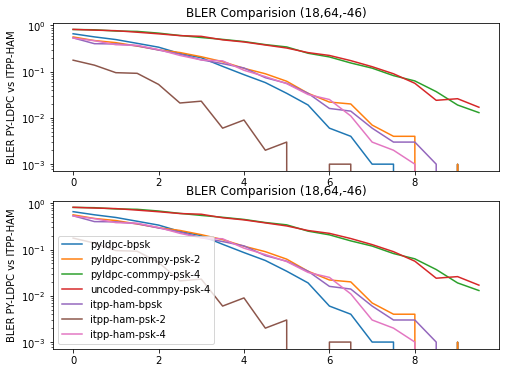

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,bler_per_iter_pyldpc,'', label="pyldpc-bpsk") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_2,'', label="pyldpc-commpy-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_4,'', label="pyldpc-commpy-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_4,'', label="itpp-uncoded-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_bpsk,'', label="itpp-ham-bpsk") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_psk_2,'', label="itpp-ham-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_psk_4,'', label="itpp-ham-psk-4") # plot BER vs SNR
ax1.set_ylabel('BLER PY-LDPC vs ITPP-HAM')
ax1.set_title('BLER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))

ax2.semilogy(snrs,bler_per_iter_pyldpc,'', label="pyldpc-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_2,'', label="pyldpc-commpy-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_4,'', label="pyldpc-commpy-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_4,'', label="uncoded-commpy-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_itpp_bpsk,'', label="itpp-ham-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_itpp_psk_2,'', label="itpp-ham-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_itpp_psk_4,'', label="itpp-ham-psk-4") # plot BER vs SNR
ax2.set_ylabel('BLER PY-LDPC vs ITPP-HAM')
ax2.set_title('BLER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

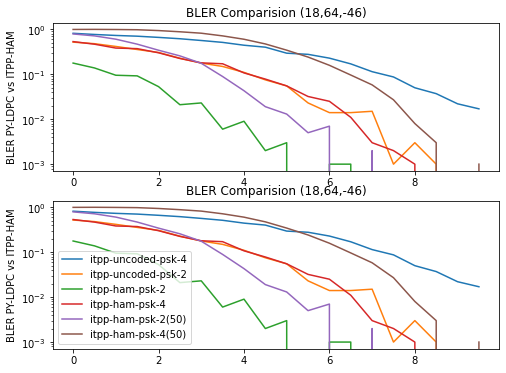

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_4,'', label="itpp-uncoded-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_2,'', label="itpp-uncoded-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_psk_2,'', label="itpp-ham-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_psk_4,'', label="itpp-ham-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_50_itpp_psk_2,'', label="itpp-ham-psk-2(50)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_50_itpp_psk_4,'', label="itpp-ham-psk-4(50)") # plot BER vs SNR
ax1.set_ylabel('BLER PY-LDPC vs ITPP-HAM')
ax1.set_title('BLER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))

ax2.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_4,'', label="itpp-uncoded-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_2,'', label="itpp-uncoded-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_itpp_psk_2,'', label="itpp-ham-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_itpp_psk_4,'', label="itpp-ham-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_50_itpp_psk_2,'', label="itpp-ham-psk-2(50)") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_50_itpp_psk_4,'', label="itpp-ham-psk-4(50)") # plot BER vs SNR
ax2.set_ylabel('BLER PY-LDPC vs ITPP-HAM')
ax2.set_title('BLER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

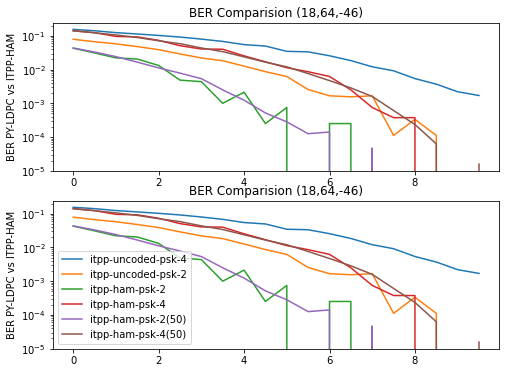

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_uncoded_itpp_psk_4,'', label="itpp-uncoded-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_uncoded_itpp_psk_2,'', label="itpp-uncoded-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_ham_itpp_psk_2,'', label="itpp-ham-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_ham_itpp_psk_4,'', label="itpp-ham-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_ham_50_itpp_psk_2,'', label="itpp-ham-psk-2(50)") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_ham_50_itpp_psk_4,'', label="itpp-ham-psk-4(50)") # plot BER vs SNR
ax1.set_ylabel('BER PY-LDPC vs ITPP-HAM')
ax1.set_title('BER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))

ax2.semilogy(snrs,ber_per_iter_uncoded_itpp_psk_4,'', label="itpp-uncoded-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_uncoded_itpp_psk_2,'', label="itpp-uncoded-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_ham_itpp_psk_2,'', label="itpp-ham-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_ham_itpp_psk_4,'', label="itpp-ham-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_ham_50_itpp_psk_2,'', label="itpp-ham-psk-2(50)") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_ham_50_itpp_psk_4,'', label="itpp-ham-psk-4(50)") # plot BER vs SNR
ax2.set_ylabel('BER PY-LDPC vs ITPP-HAM')
ax2.set_title('BER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

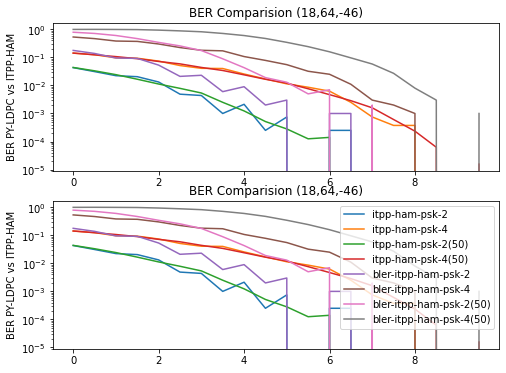

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_ham_itpp_psk_2,'', label="itpp-ham-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_ham_itpp_psk_4,'', label="itpp-ham-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_ham_50_itpp_psk_2,'', label="itpp-ham-psk-2(50)") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_ham_50_itpp_psk_4,'', label="itpp-ham-psk-4(50)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_psk_2,'', label="bler-itpp-ham-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_psk_4,'', label="bler-itpp-ham-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_50_itpp_psk_2,'', label="bler-itpp-ham-psk-2(50)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_50_itpp_psk_4,'', label="bler-itpp-ham-psk-4(50)") # plot BER vs SNR

ax1.set_ylabel('BER PY-LDPC vs ITPP-HAM')
ax1.set_title('BER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))

ax2.semilogy(snrs,ber_per_iter_ham_itpp_psk_2,'', label="itpp-ham-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_ham_itpp_psk_4,'', label="itpp-ham-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_ham_50_itpp_psk_2,'', label="itpp-ham-psk-2(50)") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_ham_50_itpp_psk_4,'', label="itpp-ham-psk-4(50)") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_itpp_psk_2,'', label="bler-itpp-ham-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_itpp_psk_4,'', label="bler-itpp-ham-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_50_itpp_psk_2,'', label="bler-itpp-ham-psk-2(50)") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_50_itpp_psk_4,'', label="bler-itpp-ham-psk-4(50)") # plot BER vs SNR

ax2.set_ylabel('BER PY-LDPC vs ITPP-HAM')
ax2.set_title('BER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

In [51]:
input_message_length = nrof_bits =14
bch = itpp.comm.bch(15, 2, False)
modulator = itpp.comm.PSK(4)
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_bch_itpp_psk_4  = numpy.array(())
ber_per_iter_bch_itpp_psk_4  = numpy.array(())
times_per_iter_bch_itpp_psk_4 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    encoded_bits = itpp.base.bvec ()
    #print ("x")
    #print (source_bits)
    bch.encode(source_bits, encoded_bits)
    #prinrt (encoded_bits)
    tx_signal = modulator.modulate_bits(encoded_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    #print (demodulated_bits)
    decoded_bits = itpp.base.bvec ()
    bch.decode(demodulated_bits, decoded_bits) 
    diffc = cout_one_in_itpp_vec (decoded_bits -  source_bits)
    #if abs(demodulated_bits != source_bits):
    if diffc != 0: 
      total_msg_error = total_msg_error + 1
      total_bit_error = total_bit_error + diffc
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    #b = itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0)
    #print (b)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = float(total_bit_error)/(NUM_OF_INPUT_MESSAGE*input_message_length)
  print('SNR: {:04.3f}:\n -> BLER: {:03.3f} BER: {:03.3f}\n -> Total Time: {:03.2f}s'.format(snr,bler, ber,total_time))
  bler_per_iter_bch_itpp_psk_4=numpy.append(bler_per_iter_bch_itpp_psk_4 ,bler)
  ber_per_iter_bch_itpp_psk_4=numpy.append(ber_per_iter_bch_itpp_psk_4 ,ber)
  times_per_iter_bch_itpp_psk_4=numpy.append(times_per_iter_bch_itpp_psk_4, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.05s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.09s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.13s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.17s
SNR: 0.000:
 -> BLER: 0.670 BER: 0.195
 -> Total Time: 0.43s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.05s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.09s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.13s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.17s
SNR: 0.500:
 -> BLER: 0.610 BER: 0.179
 -> Total Time: 0.44s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.04s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.08s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.12s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.16s
SNR: 1.000:
 -> BLER: 0.547 BER: 0.143
 -> Total Time: 0.40s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.04s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.08s
SN

In [52]:
options =itpp.ivec("18 9")
ind =itpp.ivec("")
ldpc_parity_reg = itpp.comm.ldpc_parity_regular (18, 3, 6, 'rand', options)
ldpc_gen_sym = itpp.comm.ldpc_gen_systematic (ldpc_parity_reg, False, ind)
ldpc_code = itpp.comm.ldpc_code (ldpc_parity_reg, ldpc_gen_sym, False)
input_message_length = nrof_bits = ldpc_code.get_nvar ()  - ldpc_code.get_ncheck ()
print ("nrof_bits=", nrof_bits, "nvar=", ldpc_code.get_nvar (), "ncheck=",ldpc_code.get_ncheck ())
modulator = itpp.comm.PSK(2)
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_ldpc_itpp_psk_2  = numpy.array(())
ber_per_iter_ldpc_itpp_psk_2  = numpy.array(())
times_per_iter_ldpc_itpp_psk_2 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_bit_error1 = 0
  total_msg_error = 0
  total_time = 0
  total_bit = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    encoded_bits = ldpc_code.encode(source_bits)
    #print ("x")
    #print (source_bits)
    #print (encoded_bits)
    tx_signal = modulator.modulate_bits(encoded_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    #demodulated_bits = modulator.demodulate_bits(rx_signal)
    demodulated_soft_bits = modulator.demodulate_soft_bits(rx_signal, noise_variance / ldpc_code.get_rate(), itpp.comm.Soft_Method.LOGMAP)
    #print (demodulated_soft_bits)
    decoded_soft_bits = ldpc_code.decode_soft_out(demodulated_soft_bits)
    decoded_bits = ldpc_code.decode(decoded_soft_bits)
    #print (decoded_bits)
    if abs(decoded_bits != source_bits):
      total_msg_error = total_msg_error + 1

    diffc = cout_one_in_itpp_vec (decoded_bits -  source_bits)
    if diffc != 0: 
      total_bit_error1 = total_bit_error1 + diffc

    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    total_bit_error = total_bit_error + itpp.comm.BERC.count_errors(source_bits, decoded_bits, 0, 0, 0)
    total_bit = total_bit + nrof_bits
    #print (b)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber1 = total_bit_error / total_bit
  ber = float(total_bit_error1)/(NUM_OF_INPUT_MESSAGE*input_message_length)
  print('SNR: {:04.3f}:\n -> BLER: {:03.3f} BER: {:03.3f} {:03.3f}\n -> Total Time: {:03.2f}s'.format(snr,bler, ber,ber1,total_time))
  bler_per_iter_ldpc_itpp_psk_2=numpy.append(bler_per_iter_ldpc_itpp_psk_2 ,bler)
  ber_per_iter_ldpc_itpp_psk_2=numpy.append(ber_per_iter_ldpc_itpp_psk_2 ,ber)
  times_per_iter_ldpc_itpp_psk_2=numpy.append(times_per_iter_ldpc_itpp_psk_2, total_time)

nrof_bits= 9 nvar= 18 ncheck= 9
SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.04s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.09s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.14s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.19s
SNR: 0.000:
 -> BLER: 0.084 BER: 0.017 0.017
 -> Total Time: 0.46s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.05s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.08s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.13s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.18s
SNR: 0.500:
 -> BLER: 0.063 BER: 0.014 0.014
 -> Total Time: 0.43s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.03s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.06s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.10s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.13s
SNR: 1.000:
 -> BLER: 0.030 BER: 0.006 0.006
 -> Total Time: 0.31s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.03s
SNR: 1.500

In [53]:
options =itpp.ivec("36 12")
ind =itpp.ivec("")
ldpc_parity_reg = itpp.comm.ldpc_parity_regular (100, 5, 10, 'rand', options)
ldpc_gen_sym = itpp.comm.ldpc_gen_systematic (ldpc_parity_reg, False, ind)
ldpc_code = itpp.comm.ldpc_code (ldpc_parity_reg, ldpc_gen_sym, False)
nrof_bits = ldpc_code.get_nvar ()  - ldpc_code.get_ncheck ()
print ("nrof_bits=", nrof_bits, "nvar=", ldpc_code.get_nvar (), "ncheck=",ldpc_code.get_ncheck ())
modulator = itpp.comm.PSK(4)
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_ldpc_50_100_itpp_psk_4  = numpy.array(())
ber_per_iter_ldpc_50_100_itpp_psk_4  = numpy.array(())
times_per_iter_ldpc_50_100_itpp_psk_4 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_msg_error1 = 0
  total_time = 0
  total_bit = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    encoded_bits = ldpc_code.encode(source_bits)
    #print ("x")
    #print (source_bits)
    #print (encoded_bits)
    tx_signal = modulator.modulate_bits(encoded_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    #demodulated_bits = modulator.demodulate_bits(rx_signal)
    demodulated_soft_bits = modulator.demodulate_soft_bits(rx_signal, noise_variance / ldpc_code.get_rate(), itpp.comm.Soft_Method.LOGMAP)
    #print (demodulated_soft_bits)
    decoded_soft_bits = ldpc_code.decode_soft_out(demodulated_soft_bits)
    decoded_bits = ldpc_code.decode(decoded_soft_bits)
    #print (decoded_bits)
    if abs(decoded_bits != source_bits):
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    total_bit_error = total_bit_error + itpp.comm.BERC.count_errors(source_bits, decoded_bits, 0, 0, 0)
    total_bit = total_bit + nrof_bits
    #print (b)
    blerc = itpp.comm.BLERC(nrof_bits)
    blerc.count(decoded_bits, source_bits)
    total_msg_error1 = total_msg_error1 + blerc.get_errorrate()
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = total_bit_error / total_bit
  bler1 =  float(total_msg_error1)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BLER: {:03.3f} {:03.3f} BER: {:03.3f}\n -> Total Time: {:03.2f}s'.format(snr,bler,bler1, ber,total_time))
  ber_per_iter_ldpc_50_100_itpp_psk_4=numpy.append(ber_per_iter_ldpc_50_100_itpp_psk_4 ,ber)
  bler_per_iter_ldpc_50_100_itpp_psk_4=numpy.append(bler_per_iter_ldpc_50_100_itpp_psk_4 ,bler)
  times_per_iter_ldpc_50_100_itpp_psk_4=numpy.append(times_per_iter_ldpc_50_100_itpp_psk_4, total_time)

nrof_bits= 50 nvar= 100 ncheck= 50
SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 3.70s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 7.42s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 11.11s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 14.82s
SNR: 0.000:
 -> BLER: 1.000 1.000 BER: 0.159
 -> Total Time: 37.05s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 3.70s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 7.39s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 11.09s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 14.79s
SNR: 0.500:
 -> BLER: 1.000 1.000 BER: 0.141
 -> Total Time: 36.96s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 3.70s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 7.41s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 11.11s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 14.83s
SNR: 1.000:
 -> BLER: 0.999 0.999 BER: 0.125
 -> Total Time: 37.04s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 3.72

In [54]:
print (bler_per_iter_ldpc_50_100_itpp_psk_4)
print (ber_per_iter_ldpc_50_100_itpp_psk_4)


[1.    1.    0.999 0.988 0.929 0.688 0.369 0.16  0.036 0.012 0.002 0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[1.5934e-01 1.4056e-01 1.2508e-01 1.1166e-01 9.0340e-02 5.8760e-02
 2.9380e-02 1.4040e-02 3.4600e-03 1.3000e-03 1.4000e-04 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00]


In [55]:
options =itpp.ivec("18 6")
ind =itpp.ivec("")
ldpc_parity_reg = itpp.comm.ldpc_parity_regular (18, 3, 6, 'rand', options)
ldpc_gen_sym = itpp.comm.ldpc_gen_systematic (ldpc_parity_reg, False, ind)
ldpc_code = itpp.comm.ldpc_code (ldpc_parity_reg, ldpc_gen_sym, False)
nrof_bits = ldpc_code.get_nvar ()  - ldpc_code.get_ncheck ()
print ("nrof_bits=", nrof_bits, "nvar=", ldpc_code.get_nvar (), "ncheck=",ldpc_code.get_ncheck ())
modulator = itpp.comm.PSK(4)
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_ldpc_itpp_psk_4  = numpy.array(())
ber_per_iter_ldpc_itpp_psk_4  = numpy.array(())
times_per_iter_ldpc_itpp_psk_4 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  total_bit = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    encoded_bits = ldpc_code.encode(source_bits)
    #print ("x")
    #print (source_bits)
    #print (encoded_bits)
    tx_signal = modulator.modulate_bits(encoded_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    #demodulated_bits = modulator.demodulate_bits(rx_signal)
    demodulated_soft_bits = modulator.demodulate_soft_bits(rx_signal, noise_variance / ldpc_code.get_rate(), itpp.comm.Soft_Method.LOGMAP)
    #print (demodulated_soft_bits)
    decoded_soft_bits = ldpc_code.decode_soft_out(demodulated_soft_bits)
    decoded_bits = ldpc_code.decode(decoded_soft_bits)
    #print (decoded_bits)
    if abs(decoded_bits != source_bits):
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    total_bit_error = total_bit_error + itpp.comm.BERC.count_errors(source_bits, decoded_bits, 0, 0, 0)
    total_bit = total_bit + nrof_bits
    #print (b)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = total_bit_error / total_bit
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,bler,total_time))
  ber_per_iter_ldpc_itpp_psk_4=numpy.append(ber_per_iter_ldpc_itpp_psk_4 ,ber)
  bler_per_iter_ldpc_itpp_psk_4=numpy.append(bler_per_iter_ldpc_itpp_psk_4 ,bler)
  times_per_iter_ldpc_itpp_psk_4=numpy.append(times_per_iter_ldpc_itpp_psk_4, total_time)

nrof_bits= 9 nvar= 18 ncheck= 9
SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.23s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.44s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.66s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.89s
SNR: 0.000:
 -> BER: 0.62
 -> Total Time: 2.23s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.21s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.42s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.63s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.84s
SNR: 0.500:
 -> BER: 0.59
 -> Total Time: 2.10s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.19s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.35s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.52s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.70s
SNR: 1.000:
 -> BER: 0.47
 -> Total Time: 1.77s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.14s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.28s
SNR: 1.50

In [56]:
print ("bler_per_iter_ldpc_itpp_psk_4=", bler_per_iter_ldpc_itpp_psk_4)

bler_per_iter_ldpc_itpp_psk_4= [0.62  0.588 0.466 0.364 0.271 0.195 0.117 0.069 0.051 0.008 0.013 0.
 0.001 0.001 0.    0.    0.    0.    0.    0.   ]


In [57]:
options =itpp.ivec("18 6")
ind =itpp.ivec("")
ldpc_parity_reg = itpp.comm.ldpc_parity_regular (18, 3, 6, 'rand', options)
ldpc_gen_sym = itpp.comm.ldpc_gen_systematic (ldpc_parity_reg, False, ind)
ldpc_code = itpp.comm.ldpc_code (ldpc_parity_reg, ldpc_gen_sym, False)
nrof_bits = ldpc_code.get_nvar ()  - ldpc_code.get_ncheck ()
print ("nrof_bits=", nrof_bits, "nvar=", ldpc_code.get_nvar (), "ncheck=",ldpc_code.get_ncheck ())
modulator = itpp.comm.PSK(4)
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_ldpc_itpp_bpsk  = numpy.array(())
ber_per_iter_ldpc_itpp_bpsk  = numpy.array(())
times_per_iter_ldpc_itpp_bpsk = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  total_bit = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    encoded_bits = ldpc_code.encode(source_bits)
    #print ("x")
    #print (source_bits)
    #print (encoded_bits)
    tx_signal = modulator.modulate_bits(encoded_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    #demodulated_bits = modulator.demodulate_bits(rx_signal)
    demodulated_soft_bits = modulator.demodulate_soft_bits(rx_signal, noise_variance / ldpc_code.get_rate(), itpp.comm.Soft_Method.LOGMAP)
    #print (demodulated_soft_bits)
    decoded_soft_bits = ldpc_code.decode_soft_out(demodulated_soft_bits)
    decoded_bits = ldpc_code.decode(decoded_soft_bits)
    #print (decoded_bits)
    if abs(decoded_bits != source_bits):
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    total_bit_error = total_bit_error + itpp.comm.BERC.count_errors(source_bits, decoded_bits, 0, 0, 0)
    total_bit = total_bit + nrof_bits
    #print (b)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = total_bit_error / total_bit
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,bler,total_time))
  ber_per_iter_ldpc_itpp_bpsk=numpy.append(ber_per_iter_ldpc_itpp_bpsk ,ber)
  bler_per_iter_ldpc_itpp_bpsk=numpy.append(bler_per_iter_ldpc_itpp_bpsk ,bler)
  times_per_iter_ldpc_itpp_bpsk=numpy.append(times_per_iter_ldpc_itpp_bpsk, total_time)

nrof_bits= 9 nvar= 18 ncheck= 9
SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.22s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.42s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.62s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.83s
SNR: 0.000:
 -> BER: 0.64
 -> Total Time: 2.09s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.17s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.34s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.53s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.72s
SNR: 0.500:
 -> BER: 0.55
 -> Total Time: 1.76s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.16s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.31s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.46s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.62s
SNR: 1.000:
 -> BER: 0.46
 -> Total Time: 1.55s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.12s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.24s
SNR: 1.50

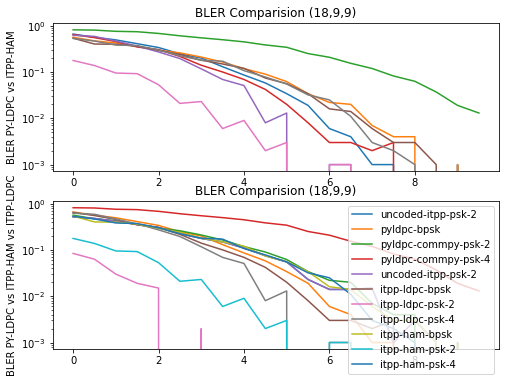

In [58]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,bler_per_iter_pyldpc,'', label="pyldpc-bpsk") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_2,'', label="pyldpc-commpy-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_4,'', label="pyldpc-commpy-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_2,'', label="uncoded-itpp-psk-2") # plot BER vs SNR

ax1.semilogy(snrs,bler_per_iter_ldpc_itpp_bpsk,'', label="itpp-ldpc-bpsk") # plot BER vs SNR
#ax1.semilogy(snrs,bler_per_iter_ldpc_itpp_psk_2,'', label="itpp-ldpc-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ldpc_itpp_psk_4,'', label="itpp-ldpc-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_bpsk,'', label="itpp-ham-bpsk") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_psk_2,'', label="itpp-ham-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_psk_4,'', label="itpp-ham-psk-4") # plot BER vs SNR
ax1.set_ylabel('BLER PY-LDPC vs ITPP-HAM')
ax1.set_title('BLER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))

ax2.semilogy(snrs,bler_per_iter_pyldpc,'', label="pyldpc-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_2,'', label="pyldpc-commpy-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_4,'', label="pyldpc-commpy-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_2,'', label="uncoded-itpp-psk-2") # plot BER vs SNR
#ax2.semilogy(snrs,bler_per_iter_ldpc_180_itpp_psk_4,'', label="uncoded-itpp-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ldpc_itpp_bpsk,'', label="itpp-ldpc-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ldpc_itpp_psk_2,'', label="itpp-ldpc-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ldpc_itpp_psk_4,'', label="itpp-ldpc-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_itpp_bpsk,'', label="itpp-ham-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_itpp_psk_2,'', label="itpp-ham-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_itpp_psk_4,'', label="itpp-ham-psk-4") # plot BER vs SNR
ax2.set_ylabel('BLER PY-LDPC vs ITPP-HAM vs ITPP-LDPC')
ax2.set_title('BLER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

In [59]:
print (bler_per_iter_ldpc_itpp_psk_4)
print (bler_per_iter_uncoded_itpp_psk_2)
print (bler_per_iter_uncoded_itpp_psk_4)

[0.62  0.588 0.466 0.364 0.271 0.195 0.117 0.069 0.051 0.008 0.013 0.
 0.001 0.001 0.    0.    0.    0.    0.    0.   ]
[0.518 0.478 0.415 0.355 0.305 0.227 0.177 0.149 0.11  0.075 0.055 0.023
 0.014 0.014 0.015 0.001 0.003 0.001 0.    0.   ]
[0.814 0.767 0.729 0.702 0.66  0.616 0.563 0.511 0.442 0.4   0.294 0.277
 0.228 0.17  0.114 0.087 0.05  0.037 0.022 0.017]


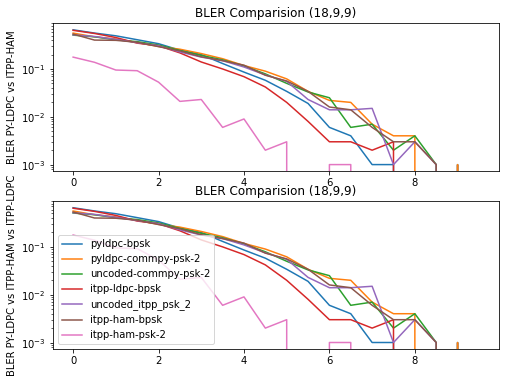

In [60]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,bler_per_iter_pyldpc,'', label="pyldpc-bpsk") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_2,'', label="pyldpc-commpy-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_2,'', label="uncoded-commpy-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ldpc_itpp_bpsk,'', label="itpp-ldpc-bpsk") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_2,'', label="uncoded_itpp_psk_2") # plot BER vs SNR
#ax1.semilogy(snrs,bler_per_iter_ldpc_itpp_psk_2,'', label="itpp-ldpc-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_bpsk,'', label="itpp-ham-bpsk") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_psk_2,'', label="itpp-ham-psk-2") # plot BER vs SNR
ax1.set_ylabel('BLER PY-LDPC vs ITPP-HAM')
ax1.set_title('BLER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))

ax2.semilogy(snrs,bler_per_iter_pyldpc,'', label="pyldpc-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_2,'', label="pyldpc-commpy-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_2,'', label="uncoded-commpy-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ldpc_itpp_bpsk,'', label="itpp-ldpc-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_2,'', label="uncoded_itpp_psk_2") # plot BER vs SNR
#ax2.semilogy(snrs,bler_per_iter_ldpc_itpp_psk_2,'', label="itpp-ldpc-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_itpp_bpsk,'', label="itpp-ham-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_itpp_psk_2,'', label="itpp-ham-psk-2") # plot BER vs SNR
ax2.set_ylabel('BLER PY-LDPC vs ITPP-HAM vs ITPP-LDPC')
ax2.set_title('BLER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

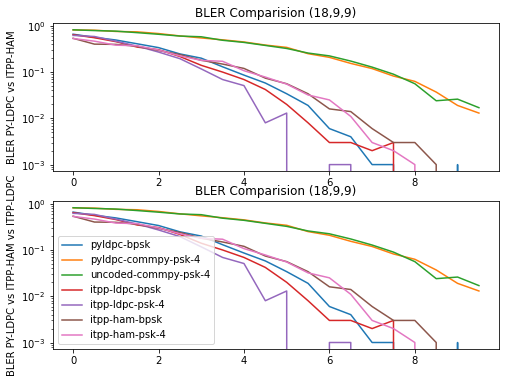

In [61]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,bler_per_iter_pyldpc,'', label="pyldpc-bpsk") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_4,'', label="pyldpc-commpy-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_4,'', label="uncoded-commpy-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ldpc_itpp_bpsk,'', label="itpp-ldpc-bpsk") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ldpc_itpp_psk_4,'', label="itpp-ldpc-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_bpsk,'', label="itpp-ham-bpsk") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_psk_4,'', label="itpp-ham-psk-4") # plot BER vs SNR
ax1.set_ylabel('BLER PY-LDPC vs ITPP-HAM')
ax1.set_title('BLER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))

ax2.semilogy(snrs,bler_per_iter_pyldpc,'', label="pyldpc-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_4,'', label="pyldpc-commpy-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_4,'', label="uncoded-commpy-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ldpc_itpp_bpsk,'', label="itpp-ldpc-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ldpc_itpp_psk_4,'', label="itpp-ldpc-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_itpp_bpsk,'', label="itpp-ham-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_itpp_psk_4,'', label="itpp-ham-psk-4") # plot BER vs SNR
ax2.set_ylabel('BLER PY-LDPC vs ITPP-HAM vs ITPP-LDPC')
ax2.set_title('BLER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

In [62]:
import numpy
def bit_error_ratio_uncoded_awgn_bpsk(snr_db):
  
    '''Generate random bits'''
    nrof_bits = 3 * 100000
    source_bits = itpp.base.randb(nrof_bits)
    
    '''Modulate the bits'''
    modulator = itpp.comm.BPSK()
    tx_signal = modulator.modulate_bits(source_bits)
    
    '''Add the effect of channel to the signal'''
    #noise_variance = itpp.math.inv_dB(-snr_db)
    noise_variance = 10 ** (-snr_db * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)

    rx_signal = channel(tx_signal)
    
    '''Demodulate the signal'''
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    
    '''Calculate the bit error ratio'''
    return itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0) / nrof_bits

def bit_error_ratio_uncoded_awgn_bpsk_c(snr_db):
    '''Generate random bits'''
    nrof_bits = 3 * 100000
    source_bits = itpp.base.randb(nrof_bits)
    
    '''Modulate the bits'''
    modulator = itpp.comm.BPSK_c()
    tx_signal = modulator.modulate_bits(source_bits)
    
    '''Add the effect of channel to the signal'''
    #noise_variance = itpp.math.inv_dB(-snr_db)
    noise_variance = 10 ** (-snr_db * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)

    rx_signal = channel(tx_signal)
    
    '''Demodulate the signal'''
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    
    '''Calculate the bit error ratio'''
    return itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0) / nrof_bits

def bit_error_ratio_uncoded_awgn_xxx(snr_db, n):
    '''Generate random bits'''
    nrof_bits = 3 * 100000
    source_bits = itpp.base.randb(nrof_bits)
    
    '''Modulate the bits'''
    modulator = itpp.comm.PSK(n)
    tx_signal = modulator.modulate_bits(source_bits)
    
    '''Add the effect of channel to the signal'''
    #noise_variance = itpp.math.inv_dB(-snr_db)
    noise_variance = 10 ** (-snr_db * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)

    rx_signal = channel(tx_signal)
    
    '''Demodulate the signal'''
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    
    '''Calculate the bit error ratio'''
    return itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0) / nrof_bits

'''SNR range'''
snrs_db = numpy.arange (SNR_BEGIN, SNR_END+20, SNR_STEP_SIZE)

print('BER Started')
ber_itpp_uncoded_bpsk = [bit_error_ratio_uncoded_awgn_bpsk(snr) for snr in snrs_db]
ber_itpp_uncoded_bpsk_c = [bit_error_ratio_uncoded_awgn_bpsk_c(snr) for snr in snrs_db]
ber_itpp_uncoded_psk_2 = [bit_error_ratio_uncoded_awgn_xxx(snr, 2) for snr in snrs_db]
ber_itpp_uncoded_psk_4 = [bit_error_ratio_uncoded_awgn_xxx(snr, 4) for snr in snrs_db]
ber_itpp_uncoded_psk_8 = [bit_error_ratio_uncoded_awgn_xxx(snr, 8) for snr in snrs_db]
ber_itpp_uncoded_psk_16 = [bit_error_ratio_uncoded_awgn_xxx(snr, 16) for snr in snrs_db]
print('BER Finished')

BER Started
BER Finished


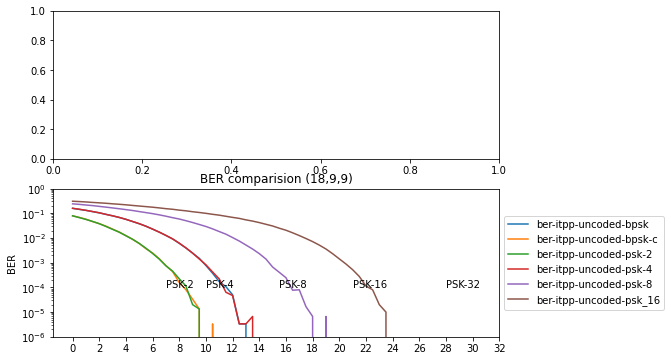

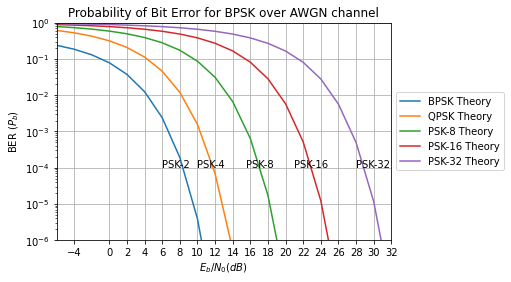

In [95]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs_db = numpy.arange (SNR_BEGIN, SNR_END+20, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax2.semilogy(snrs_db,ber_itpp_uncoded_bpsk,'', label="ber-itpp-uncoded-bpsk") # plot BER vs SNR
ax2.semilogy(snrs_db,ber_itpp_uncoded_bpsk_c,'', label="ber-itpp-uncoded-bpsk-c") # plot BER vs SNR
ax2.semilogy(snrs_db,ber_itpp_uncoded_psk_2,'', label="ber-itpp-uncoded-psk-2") # plot BER vs SNR
ax2.semilogy(snrs_db,ber_itpp_uncoded_psk_4,'', label="ber-itpp-uncoded-psk-4") # plot BER vs SNR
ax2.semilogy(snrs_db,ber_itpp_uncoded_psk_8,'', label="ber-itpp-uncoded-psk-8") # plot BER vs SNR
ax2.semilogy(snrs_db,ber_itpp_uncoded_psk_16,'', label="ber-itpp-uncoded-psk_16") # plot BER vs SNR
ax2.set_ylabel('BER')
ax2.set_title('BER comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
ax2.annotate('',
            xy=(1, 0.35), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
#plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.xticks(plot_x_axis)

ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax2.set_ylim(0.000001,1);

plt.text(7, 0.0001, 'PSK-2')
#plt.text(6.5, 0.001, 'QAM-8')
plt.text(10, 0.0001, 'PSK-4')
plt.text(15.5, 0.0001, 'PSK-8')
plt.text(21, 0.0001, 'PSK-16')
plt.text(28, 0.0001, 'PSK-32')

plt.show()
import numpy as np #for numerical computing
import matplotlib.pyplot as plt #for plotting functions
from scipy.special import erfc
import math

EbN0dBs = np.arange(start=-6,stop = 33, step = 2)
BPSK_BER_theory = 0.5*erfc(np.sqrt(10**(EbN0dBs/10)))
M=4
#QAM_BER_theory = 2*(1-np.sqrt(1/M))*erfc(np.sqrt(10**(EbN0dBs/10)))
QAM_BER_theory = erfc(np.sqrt(math.log2(M)*3/(2*(M-1)))*np.sqrt(10**(EbN0dBs/10)))
QPSK_BER_theory = erfc(math.sin(math.pi/M)*np.sqrt(10**(EbN0dBs/10)))
M=8
PSK_8_BER_theory = erfc(math.sin(math.pi/M)*np.sqrt(10**(EbN0dBs/10)))
QAM_8_BER_theory = 2*erfc(np.sqrt(math.log2(M)*3/(2*(M-1)))*np.sqrt(10**(EbN0dBs/10)))
M=16
PSK_16_BER_theory = erfc(math.sin(math.pi/M)*np.sqrt(10**(EbN0dBs/10)))
QAM_16_BER_theory = 2*erfc(np.sqrt(math.log2(M)*3/(2*(M-1)))*np.sqrt(10**(EbN0dBs/10)))
M=32
PSK_32_BER_theory = erfc(math.sin(math.pi/M)*np.sqrt(10**(EbN0dBs/10)))

fig, ax = plt.subplots(nrows=1,ncols = 1)
ax.semilogy(EbN0dBs,BPSK_BER_theory,marker='',linestyle='-',label='BPSK Theory')
ax.semilogy(EbN0dBs,QPSK_BER_theory,marker='',linestyle='-',label='QPSK Theory')
#ax.semilogy(EbN0dBs,QAM_BER_theory,marker='',linestyle='-',label='QAM Theory')
ax.semilogy(EbN0dBs,PSK_8_BER_theory,marker='',linestyle='-',label='PSK-8 Theory')
#ax.semilogy(EbN0dBs,QAM_8_BER_theory,marker='',linestyle='-',label='QAM-8 Theory')
ax.semilogy(EbN0dBs,PSK_16_BER_theory,marker='',linestyle='-',label='PSK-16 Theory')
#ax.semilogy(EbN0dBs,QAM_16_BER_theory,marker='',linestyle='-',label='QAM-16 Theory')
ax.semilogy(EbN0dBs,PSK_32_BER_theory,marker='',linestyle='-',label='PSK-32 Theory')
ax.set_xlabel('$E_b/N_0(dB)$');ax.set_ylabel('BER ($P_b$)')
ax.set_title('Probability of Bit Error for BPSK over AWGN channel')
ax.set_ylim(0.000001,1);
ax.grid(True);
ax.set_xlim(-6,30);
ax.grid(True);
ax.legend();
x = [-4,0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32]
#x = [-4,0,4,8,12,16,20,24,28,32]
plt.xticks(x)
plt.text(6, 0.0001, 'PSK-2')
#plt.text(6.5, 0.001, 'QAM-8')
plt.text(10, 0.0001, 'PSK-4')
plt.text(15.5, 0.0001, 'PSK-8')
plt.text(21, 0.0001, 'PSK-16')
plt.text(28, 0.0001, 'PSK-32')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#ax.get_legend().remove()
plt.show()

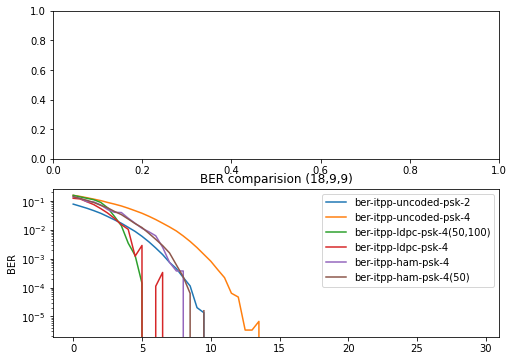

In [64]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END+20, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
#ax2.semilogy(snrs_db,ber_itpp_uncoded_bpsk,'', label="ber-itpp-uncoded-bpsk") # plot BER vs SNR
#ax2.semilogy(snrs_db,ber_itpp_uncoded_bpsk_c,'', label="ber-itpp-uncoded-bpsk-c") # plot BER vs SNR
ax2.semilogy(snrs_db,ber_itpp_uncoded_psk_2,'', label="ber-itpp-uncoded-psk-2") # plot BER vs SNR
ax2.semilogy(snrs_db,ber_itpp_uncoded_psk_4,'', label="ber-itpp-uncoded-psk-4") # plot BER vs SNR
#ax2.semilogy(snrs_db[0:20],ber_per_iter_ldpc_itpp_bpsk,'', label="ber-itpp-ldpc-bpsk") # plot BER vs SNR
ax2.semilogy(snrs_db[0:20],ber_per_iter_ldpc_50_100_itpp_psk_4,'', label="ber-itpp-ldpc-psk-4(50,100)") # plot BER vs SNR
#ax2.semilogy(snrs_db[0:20],ber_per_iter_ldpc_itpp_psk_2,'', label="ber-itpp-ldpc-psk-2") # plot BER vs SNR
ax2.semilogy(snrs_db[0:20],ber_per_iter_ldpc_itpp_psk_4,'', label="ber-itpp-ldpc-psk-4") # plot BER vs SNR
ax2.semilogy(snrs_db[0:20],ber_per_iter_ham_itpp_psk_4,'', label="ber-itpp-ham-psk-4") # plot BER vs SNR
ax2.semilogy(snrs_db[0:20],ber_per_iter_ham_50_itpp_psk_4,'', label="ber-itpp-ham-psk-4(50)") # plot BER vs SNR
ax2.set_ylabel('BER')
ax2.set_title('BER comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
ax2.annotate('',
            xy=(1, 0.35), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
#plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

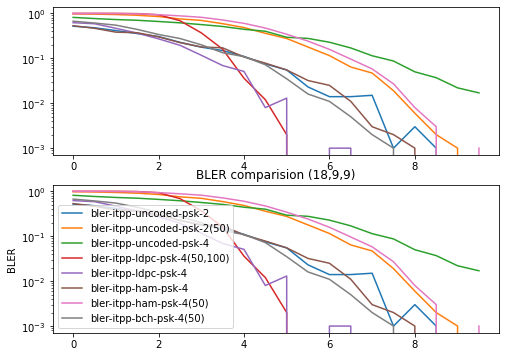

In [65]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs_db = numpy.arange (SNR_BEGIN, SNR_END+20, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs[0:20],bler_per_iter_uncoded_itpp_psk_2,'', label="bler-itpp-uncoded-psk-2") # plot BER vs SNR
ax1.semilogy(snrs_db[0:20],bler_per_iter_uncoded_50_itpp_psk_2,'', label="bler-itpp-uncoded-psk-2(50)") # plot BER vs SNR
ax1.semilogy(snrs_db[0:20],bler_per_iter_uncoded_itpp_psk_4,'', label="bler-itpp-uncoded-psk-4") # plot BER vs SNR
ax1.semilogy(snrs_db[0:20],bler_per_iter_ldpc_50_100_itpp_psk_4 ,'', label="bler-itpp-ldpc-psk-4(50,100)") # plot BER vs SNR
ax1.semilogy(snrs_db[0:20],bler_per_iter_ldpc_itpp_psk_4,'', label="bler-itpp-ldpc-psk-4") # plot BER vs SNR
ax1.semilogy(snrs_db[0:20],bler_per_iter_ham_itpp_psk_4,'', label="bler-itpp-ham-psk-4") # plot BER vs SNR
ax1.semilogy(snrs_db[0:20],bler_per_iter_ham_50_itpp_psk_4,'', label="bler-itpp-ham-psk-4(50)") # plot BER vs SNR
ax1.semilogy(snrs_db[0:20],bler_per_iter_bch_itpp_psk_4,'', label="bler-itpp-bch-psk-4(50)") # plot BER vs SNR

ax2.semilogy(snrs_db[0:20],bler_per_iter_uncoded_itpp_psk_2,'', label="bler-itpp-uncoded-psk-2") # plot BER vs SNR
ax2.semilogy(snrs_db[0:20],bler_per_iter_uncoded_50_itpp_psk_2,'', label="bler-itpp-uncoded-psk-2(50)") # plot BER vs SNR
ax2.semilogy(snrs_db[0:20],bler_per_iter_uncoded_itpp_psk_4,'', label="bler-itpp-uncoded-psk-4") # plot BER vs SNR
ax2.semilogy(snrs_db[0:20],bler_per_iter_ldpc_50_100_itpp_psk_4 ,'', label="bler-itpp-ldpc-psk-4(50,100)") # plot BER vs SNR
ax2.semilogy(snrs_db[0:20],bler_per_iter_ldpc_itpp_psk_4,'', label="bler-itpp-ldpc-psk-4") # plot BER vs SNR
ax2.semilogy(snrs_db[0:20],bler_per_iter_ham_itpp_psk_4,'', label="bler-itpp-ham-psk-4") # plot BER vs SNR
ax2.semilogy(snrs_db[0:20],bler_per_iter_ham_50_itpp_psk_4,'', label="bler-itpp-ham-psk-4(50)") # plot BER vs SNR
ax2.semilogy(snrs_db[0:20],bler_per_iter_bch_itpp_psk_4,'', label="bler-itpp-bch-psk-4(50)") # plot BER vs SNR
ax2.set_ylabel('BLER')
ax2.set_title('BLER comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
ax2.annotate('',
            xy=(1, 0.35), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
#plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

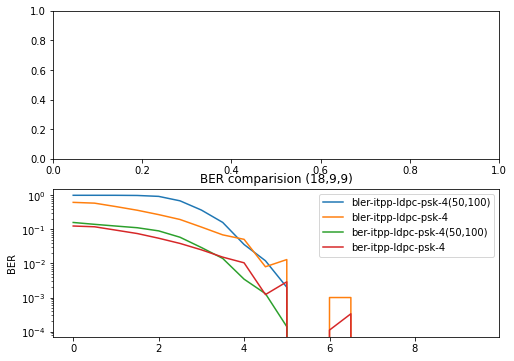

In [66]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END+20, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax2.semilogy(snrs_db[0:20],bler_per_iter_ldpc_50_100_itpp_psk_4 ,'', label="bler-itpp-ldpc-psk-4(50,100)") # plot BER vs SNR
ax2.semilogy(snrs_db[0:20],bler_per_iter_ldpc_itpp_psk_4,'', label="bler-itpp-ldpc-psk-4") # plot BER vs SNR
ax2.semilogy(snrs_db[0:20],ber_per_iter_ldpc_50_100_itpp_psk_4 ,'', label="ber-itpp-ldpc-psk-4(50,100)") # plot BER vs SNR
ax2.semilogy(snrs_db[0:20],ber_per_iter_ldpc_itpp_psk_4,'', label="ber-itpp-ldpc-psk-4") # plot BER vs SNR

ax2.set_ylabel('BER')
ax2.set_title('BER comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
ax2.annotate('',
            xy=(1, 0.35), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
#plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

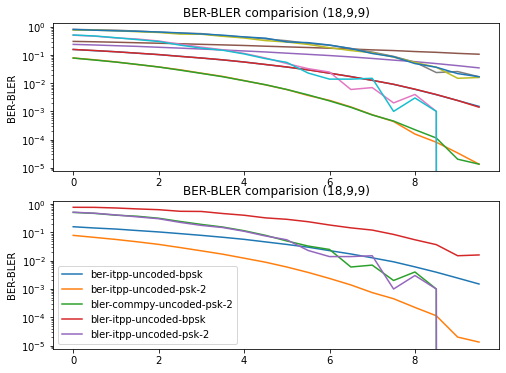

In [67]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,ber_itpp_uncoded_bpsk[0:20],'', label="ber-itpp-uncoded-bpsk") # plot BER vs SNR
ax1.semilogy(snrs,ber_itpp_uncoded_bpsk_c[0:20],'', label="ber-itpp-uncoded-bpsk-c") # plot BER vs SNR
ax1.semilogy(snrs,ber_itpp_uncoded_psk_2[0:20],'', label="ber-itpp-uncoded-psk_2") # plot BER vs SNR
ax1.semilogy(snrs,ber_itpp_uncoded_psk_4[0:20],'', label="ber-itpp-uncoded-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,ber_itpp_uncoded_psk_8[0:20],'', label="ber-itpp-uncoded-psk-8") # plot BER vs SNR
ax1.semilogy(snrs,ber_itpp_uncoded_psk_16[0:20],'', label="ber-itpp-uncoded-psk-16") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_2 ,'', label="bler-commpy-uncoded-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_4,'', label="bler-commpy-uncoded-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_itpp_bpsk,'', label="bler-itpp-uncoded-bpsk") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_2,'', label="bler-itpp-uncoded-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_4,'', label="bler-itpp-uncoded-psk-4") # plot BER vs SNR
ax1.set_ylabel('BER-BLER')
ax1.set_title('BER-BLER comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
ax1.annotate('',
            xy=(1, 0.35), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
ax2.semilogy(snrs,ber_itpp_uncoded_bpsk[0:20],'', label="ber-itpp-uncoded-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,ber_itpp_uncoded_psk_2[0:20],'', label="ber-itpp-uncoded-psk-2") # plot BER vs SNR
#ax2.semilogy(snrs,ber_unc_qpsk[0:20],'', label="ber_unc_qpsk") # plot BER vs SNR
#ax2.semilogy(snrs,ber_unc_8psk[0:20],'', label="ber_unc_8psk") # plot BER vs SNR
#ax2.semilogy(snrs,ber_unc_16psk[0:20],'', label="ber_unc_16psk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_2 ,'', label="bler-commpy-uncoded-psk-2") # plot BER vs SNR
#ax2.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_4,'', label="commpy-uncoded-qpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_itpp_bpsk,'', label="bler-itpp-uncoded-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_2,'', label="bler-itpp-uncoded-psk-2") # plot BER vs SNR
#ax2.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_4,'', label="itpp-uncoded-psk-4") # plot BER vs SNR
ax2.set_ylabel('BER-BLER')
ax2.set_title('BER-BLER comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
ax2.annotate('',
            xy=(1, 0.35), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
#plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

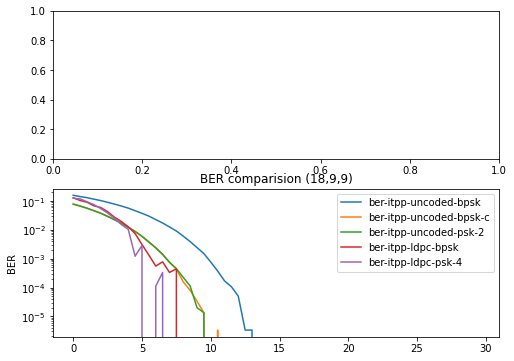

In [68]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END+20, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax2.semilogy(snrs_db,ber_itpp_uncoded_bpsk,'', label="ber-itpp-uncoded-bpsk") # plot BER vs SNR
ax2.semilogy(snrs_db,ber_itpp_uncoded_bpsk_c,'', label="ber-itpp-uncoded-bpsk-c") # plot BER vs SNR
ax2.semilogy(snrs_db,ber_itpp_uncoded_psk_2,'', label="ber-itpp-uncoded-psk-2") # plot BER vs SNR
ax2.semilogy(snrs_db[0:20],ber_per_iter_ldpc_itpp_bpsk,'', label="ber-itpp-ldpc-bpsk") # plot BER vs SNR
#ax2.semilogy(snrs_db[0:20],ber_per_iter_ldpc_itpp_psk_2,'', label="ber-itpp-ldpc-psk-2") # plot BER vs SNR
ax2.semilogy(snrs_db[0:20],ber_per_iter_ldpc_itpp_psk_4,'', label="ber-itpp-ldpc-psk-4") # plot BER vs SNR
ax2.set_ylabel('BER')
ax2.set_title('BER comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
ax2.annotate('',
            xy=(1, 0.35), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
#plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

No Bit Errors :)
No Bit Errors :)
2 Bit Errors found!
No Bit Errors :)


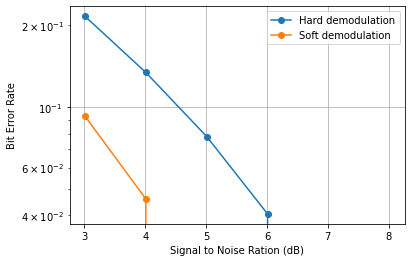

In [69]:
#https://github.com/veeresht/CommPy/blob/master/commpy/examples/conv_encode_decode.py
# Authors: CommPy contributors
# License: BSD 3-Clause

from __future__ import division, print_function  # Python 2 compatibility

import math

import matplotlib.pyplot as plt
import numpy as np

import commpy.channelcoding.convcode as cc
import commpy.channels as chan
import commpy.links as lk
import commpy.modulation as mod
import commpy.utilities as util

# =============================================================================
# Convolutional Code 1: G(D) = [1+D^2, 1+D+D^2]
# Standard code with rate 1/2
# =============================================================================

# Number of delay elements in the convolutional encoder
memory = np.array(2, ndmin=1)

# Generator matrix
g_matrix = np.array((0o5, 0o7), ndmin=2)

# Create trellis data structure
trellis1 = cc.Trellis(memory, g_matrix)

# =============================================================================
# Convolutional Code 1: G(D) = [1+D^2, 1+D^2+D^3]
# Standard code with rate 1/2
# =============================================================================

# Number of delay elements in the convolutional encoder
memory = np.array(3, ndmin=1)

# Generator matrix (1+D^2+D^3 <-> 13 or 0o15)
g_matrix = np.array((0o5, 0o15), ndmin=2)

# Create trellis data structure
trellis2 = cc.Trellis(memory, g_matrix)

# =============================================================================
# Convolutional Code 2: G(D) = [[1, 0, 0], [0, 1, 1+D]]; F(D) = [[D, D], [1+D, 1]]
# RSC with rate 2/3
# =============================================================================

# Number of delay elements in the convolutional encoder
memory = np.array((1, 1))

# Generator matrix & feedback matrix
g_matrix = np.array(((1, 0, 0), (0, 1, 3)))
feedback = np.array(((2, 2), (3, 1)))

# Create trellis data structure
trellis3 = cc.Trellis(memory, g_matrix, feedback, 'rsc')

# =============================================================================
# Basic example using homemade counting and hard decoding
# =============================================================================

# Traceback depth of the decoder
tb_depth = None  # Default value is 5 times the number or memories

for trellis in (trellis1, trellis2, trellis3):
    for i in range(10):
        # Generate random message bits to be encoded
        message_bits = np.random.randint(0, 2, 1000)

        # Encode message bits
        coded_bits = cc.conv_encode(message_bits, trellis)

        # Introduce bit errors (channel)
        coded_bits[np.random.randint(0, 1000)] = 0
        coded_bits[np.random.randint(0, 1000)] = 0
        coded_bits[np.random.randint(0, 1000)] = 1
        coded_bits[np.random.randint(0, 1000)] = 1

        # Decode the received bits
        decoded_bits = cc.viterbi_decode(coded_bits.astype(float), trellis, tb_depth)

        num_bit_errors = util.hamming_dist(message_bits, decoded_bits[:len(message_bits)])

        if num_bit_errors != 0:
            print(num_bit_errors, "Bit Errors found!")
        elif i == 9:
            print("No Bit Errors :)")

# ==================================================================================================
# Complete example using Commpy features and compare hard and soft demodulation. Example with code 1
# ==================================================================================================

# Modem : QPSK
modem = mod.QAMModem(4)

# AWGN channel
channels = chan.SISOFlatChannel(None, (1 + 0j, 0j))

# SNR range to test
SNRs = np.arange(0, 6) + 10 * math.log10(modem.num_bits_symbol)


# Modulation function
def modulate(bits):
    return modem.modulate(cc.conv_encode(bits, trellis1, 'cont'))


# Receiver function (no process required as there are no fading)
def receiver_hard(y, h, constellation, noise_var):
    return modem.demodulate(y, 'hard')


# Receiver function (no process required as there are no fading)
def receiver_soft(y, h, constellation, noise_var):
    return modem.demodulate(y, 'soft', noise_var)


# Decoder function
def decoder_hard(msg):
    return cc.viterbi_decode(msg, trellis1)


# Decoder function
def decoder_soft(msg):
    return cc.viterbi_decode(msg, trellis1, decoding_type='soft')


# Build model from parameters
code_rate = trellis1.k / trellis1.n
model_hard = lk.LinkModel(modulate, channels, receiver_hard,
                          modem.num_bits_symbol, modem.constellation, modem.Es,
                          decoder_hard, code_rate)
model_soft = lk.LinkModel(modulate, channels, receiver_soft,
                          modem.num_bits_symbol, modem.constellation, modem.Es,
                          decoder_soft, code_rate)

# Test
BERs_hard = model_hard.link_performance(SNRs, 10000, 600, 5000, code_rate)
BERs_soft = model_soft.link_performance(SNRs, 10000, 600, 5000, code_rate)
plt.semilogy(SNRs, BERs_hard, 'o-', SNRs, BERs_soft, 'o-')
plt.grid()
plt.xlabel('Signal to Noise Ration (dB)')
plt.ylabel('Bit Error Rate')
plt.legend(('Hard demodulation', 'Soft demodulation'))
plt.show()

In [70]:
print (bler_per_iter_ldpc_itpp_psk_2)
print ("bler_per_iter_uncoded_commpy_psk_2=",  bler_per_iter_uncoded_commpy_psk_2, sep=", ")
print ("bler_per_iter_uncoded_itpp_psk_2=",  bler_per_iter_uncoded_itpp_psk_2)
print ("bler_per_iter_uncoded_commpy_psk_4=",  bler_per_iter_uncoded_commpy_psk_4, sep=", ")
print ("bler_per_iter_uncoded_itpp_psk_4=",  bler_per_iter_uncoded_itpp_psk_4)
print ("bler_per_iter_uncoded_itpp_psk_8=",  bler_per_iter_uncoded_itpp_psk_8)

[0.084 0.063 0.03  0.019 0.015 0.    0.002 0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
bler_per_iter_uncoded_commpy_psk_2=, [0.51  0.471 0.407 0.373 0.317 0.244 0.192 0.155 0.115 0.079 0.05  0.033
 0.025 0.006 0.007 0.002 0.004 0.001 0.    0.   ]
bler_per_iter_uncoded_itpp_psk_2= [0.518 0.478 0.415 0.355 0.305 0.227 0.177 0.149 0.11  0.075 0.055 0.023
 0.014 0.014 0.015 0.001 0.003 0.001 0.    0.   ]
bler_per_iter_uncoded_commpy_psk_4=, [0.82  0.79  0.768 0.712 0.657 0.601 0.58  0.487 0.438 0.377 0.324 0.258
 0.224 0.173 0.128 0.09  0.056 0.024 0.026 0.017]
bler_per_iter_uncoded_itpp_psk_4= [0.814 0.767 0.729 0.702 0.66  0.616 0.563 0.511 0.442 0.4   0.294 0.277
 0.228 0.17  0.114 0.087 0.05  0.037 0.022 0.017]
bler_per_iter_uncoded_itpp_psk_8= [0.921 0.917 0.912 0.867 0.86  0.857 0.826 0.808 0.77  0.737 0.704 0.657
 0.608 0.6   0.547 0.487 0.426 0.361 0.323 0.293]


In [71]:
print (bler_per_iter_ldpc_itpp_psk_2)
print ("bler_per_iter_uncoded_commpy_psk_2=",  bler_per_iter_uncoded_commpy_psk_2, sep=", ")
print ("bler_per_iter_uncoded_itpp_psk_2=",  bler_per_iter_uncoded_itpp_psk_2)
print ("bler_per_iter_uncoded_commpy_psk_4=",  bler_per_iter_uncoded_commpy_psk_4, sep=", ")
print ("bler_per_iter_uncoded_itpp_psk_4=",  bler_per_iter_uncoded_itpp_psk_4)
print ("bler_per_iter_uncoded_itpp_psk_8=",  bler_per_iter_uncoded_itpp_psk_8)
print ("bler_per_iter_uncoded_commpy_psk_8=",  bler_per_iter_uncoded_commpy_psk_8)

[0.084 0.063 0.03  0.019 0.015 0.    0.002 0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
bler_per_iter_uncoded_commpy_psk_2=, [0.51  0.471 0.407 0.373 0.317 0.244 0.192 0.155 0.115 0.079 0.05  0.033
 0.025 0.006 0.007 0.002 0.004 0.001 0.    0.   ]
bler_per_iter_uncoded_itpp_psk_2= [0.518 0.478 0.415 0.355 0.305 0.227 0.177 0.149 0.11  0.075 0.055 0.023
 0.014 0.014 0.015 0.001 0.003 0.001 0.    0.   ]
bler_per_iter_uncoded_commpy_psk_4=, [0.82  0.79  0.768 0.712 0.657 0.601 0.58  0.487 0.438 0.377 0.324 0.258
 0.224 0.173 0.128 0.09  0.056 0.024 0.026 0.017]
bler_per_iter_uncoded_itpp_psk_4= [0.814 0.767 0.729 0.702 0.66  0.616 0.563 0.511 0.442 0.4   0.294 0.277
 0.228 0.17  0.114 0.087 0.05  0.037 0.022 0.017]
bler_per_iter_uncoded_itpp_psk_8= [0.921 0.917 0.912 0.867 0.86  0.857 0.826 0.808 0.77  0.737 0.704 0.657
 0.608 0.6   0.547 0.487 0.426 0.361 0.323 0.293]
bler_per_iter_uncoded_commpy_psk_8= [0.939 0.919 0.895 0.86  0.868 0.853 0.823 0.792 0.78

In [72]:
print ("bler_per_iter_ham_itpp_bpsk", bler_per_iter_ham_itpp_bpsk)
print ("bler_per_iter_ham_itpp_psk_4", bler_per_iter_ham_itpp_psk_4)

bler_per_iter_ham_itpp_bpsk [0.537 0.402 0.397 0.362 0.293 0.239 0.18  0.149 0.12  0.074 0.056 0.034
 0.016 0.014 0.006 0.003 0.003 0.001 0.    0.   ]
bler_per_iter_ham_itpp_psk_4 [0.532 0.466 0.382 0.371 0.3   0.224 0.179 0.171 0.107 0.078 0.055 0.032
 0.025 0.011 0.003 0.002 0.001 0.    0.    0.   ]


In [73]:
print (bler_per_iter_ldpc_50_100_itpp_psk_4)
print (bler_per_iter_uncoded_100_commpy_psk_4)
print (bler_per_iter_uncoded_100_itpp_psk_4)

print (ber_per_iter_ldpc_50_100_itpp_psk_4)


[1.    1.    0.999 0.988 0.929 0.688 0.369 0.16  0.036 0.012 0.002 0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[1.    1.    1.    1.    1.    1.    1.    1.    0.998 0.991 0.971 0.942
 0.911 0.823 0.711 0.598 0.422 0.334 0.207 0.123]
[1.    1.    1.    1.    1.    1.    1.    0.998 0.999 0.992 0.986 0.955
 0.904 0.834 0.69  0.606 0.464 0.305 0.209 0.138]
[1.5934e-01 1.4056e-01 1.2508e-01 1.1166e-01 9.0340e-02 5.8760e-02
 2.9380e-02 1.4040e-02 3.4600e-03 1.3000e-03 1.4000e-04 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00]


In [74]:
# File:   hamming.py
# Brief:  Simulates a Hamming coded radio link over AWGN channel
# Author: Vidit Saxena
#
# Usage:  import hamming
#
# -------------------------------------------------------------------------
#
# Copyright (C) 2016 CC0 1.0 Universal (CC0 1.0) 
#
# The person who associated a work with this deed has dedicated the work to
# the public domain by waiving all of his or her rights to the work 
# worldwide under copyright law, including all related and neighboring 
# rights, to the extent allowed by law.
#
# You can copy, modify, distribute and perform the work, even for commercial 
# purposes, all without asking permission.
#
# See the complete legal text at 
# <https://creativecommons.org/publicdomain/zero/1.0/legalcode>
#
# -------------------------------------------------------------------------

#import itpp

def block_error_ratio_hamming_awgn(snr_db, block_size):
    
    mapping_k_m = {4: 3} # Mapping from k (block size) to m. m = 3 implies (7,4) code
    m = mapping_k_m[block_size]
     
    '''Hamming encoder and decoder instance'''
    hamm = itpp.comm.Hamming_Code(m)
    n = pow(2,m) - 1 # channel use
    rate = float(block_size)/float(n)
    
    '''Generate random bits'''
    nrof_bits = 10000 * block_size
    source_bits = itpp.randb(nrof_bits)
    
    '''Encode the bits'''
    encoded_bits = hamm.encode(source_bits)
    
    '''Modulate the bits'''
    modulator_ = itpp.comm.modulator_2d()
    constellation = itpp.cvec('-1+0i, 1+0i')
    symbols = itpp.ivec('0, 1')
    modulator_.set(constellation, symbols)
    tx_signal = modulator_.modulate_bits(encoded_bits)
    
    '''Add the effect of channel to the signal'''
    #rate = 1.0 # VIJAYA_MODIFY
    noise_variance = 1.0 / (rate * pow(10, 0.1 * snr_db))
    print ("block_error_ratio_hamming_awgn:noise_var:", noise_variance, " ", snr_db)
    noise = itpp.randn_c(tx_signal.length())
    noise *= itpp.math.sqrt(noise_variance)
    rx_signal = tx_signal + noise
    
    '''Demodulate the signal'''
    demodulated_bits = modulator_.demodulate_bits(rx_signal)
    
    '''Decode the received bits'''
    decoded_bits = hamm.decode(demodulated_bits) 
    
    '''Calculate the block error ratio'''
    blerc = itpp.comm.BLERC(block_size)
    blerc.count(source_bits, decoded_bits)
    return blerc.get_errorrate()

In [75]:
# File:   uncoded.py
# Brief:  Simulates uncoded link over AWGN channel 
# Author: Vidit Saxena
#
# Usage:  import uncoded
#
# -------------------------------------------------------------------------
#
# Copyright (C) 2016 CC0 1.0 Universal (CC0 1.0) 
#
# The person who associated a work with this deed has dedicated the work to
# the public domain by waiving all of his or her rights to the work 
# worldwide under copyright law, including all related and neighboring 
# rights, to the extent allowed by law.
#
# You can copy, modify, distribute and perform the work, even for commercial 
# purposes, all without asking permission.
#
# See the complete legal text at 
# <https://creativecommons.org/publicdomain/zero/1.0/legalcode>
#
# -------------------------------------------------------------------------



def block_error_ratio_uncoded_awgn(snr_db, block_size):
    '''Generate random bits'''
    nrof_bits = 3 * 10000 * block_size
    source_bits = itpp.randb(nrof_bits)
    rate = 1.0
    
    '''Modulate the bits'''
    modulator_ = itpp.comm.modulator_2d()
    constellation = itpp.cvec('-1+0i, 1+0i')
    symbols = itpp.ivec('0, 1')
    modulator_.set(constellation, symbols)
    tx_signal = modulator_.modulate_bits(source_bits)
    
    '''Add the effect of channel to the signal'''
    noise_variance = 1.0 / (rate * pow(10, 0.1 * snr_db))
    print ("block_error_ratio_uncoded_awgn:noise_var:",noise_variance, " ", snr_db)
    noise = itpp.randn_c(tx_signal.length())
    noise *= itpp.math.sqrt(noise_variance)
    rx_signal = tx_signal + noise
    
    '''Demodulate the signal'''
    demodulated_bits = modulator_.demodulate_bits(rx_signal)
    
    '''Calculate the block error ratio'''
    blerc = itpp.comm.BLERC(block_size)
    blerc.count(source_bits, demodulated_bits)
    return blerc.get_errorrate()

In [76]:
# File:   autoencoder.py
# Brief:  Neural network autoencoded radio link over AWGN channel 
# Author: Vidit Saxena
#
# Usage:  import autoencoder
#
# -------------------------------------------------------------------------
#
# Copyright (C) 2016 CC0 1.0 Universal (CC0 1.0) 
#
# The person who associated a work with this deed has dedicated the work to
# the public domain by waiving all of his or her rights to the work 
# worldwide under copyright law, including all related and neighboring 
# rights, to the extent allowed by law.
#
# You can copy, modify, distribute and perform the work, even for commercial 
# purposes, all without asking permission.
#
# See the complete legal text at 
# <https://creativecommons.org/publicdomain/zero/1.0/legalcode>
#
# -------------------------------------------------------------------------

import tensorflow as tf
import numpy as np

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior ()

def block_error_ratio_autoencoder_awgn(snrs_db, block_size, channel_use, batch_size, nrof_steps):
    
    print('block_size %d'%(block_size))
    print('channel_use %d'%(channel_use))
    
    rate = float(block_size)/float(channel_use)
    print('rate %0.2f'%(rate))
    
    '''The input is one-hot encoded vector for each codeword'''
    alphabet_size = pow(2, block_size)
    alphabet = np.eye(alphabet_size, dtype = 'float32') # One-hot encoded values
    
    '''Repeat the alphabet to create training and test datasets'''
    train_dataset = np.transpose(np.tile(alphabet, int(batch_size)))
    test_dataset = np.transpose(np.tile(alphabet, int(batch_size * 1000)))
    
    print('--Setting up autoencoder graph--')
    input, output, noise_std_dev, h_norm = _implement_autoencoder(alphabet_size, channel_use)
    
    print( '--Setting up training scheme--')
    train_step = _implement_training(output, input)
    
    print('--Setting up accuracy--')
    accuracy = _implement_accuracy(output, input)

    print('--Starting the tensorflow session--')
    sess = _setup_interactive_tf_session()
    _init_and_start_tf_session(sess)
    
    print('--Training the autoencoder over awgn channel--')
    _train(train_step, input, noise_std_dev, nrof_steps, train_dataset, snrs_db, rate, accuracy)
    
    print('--Evaluating autoencoder performance--')
    bler = _evaluate(input, noise_std_dev, test_dataset, snrs_db, rate, accuracy)
    
    print('--Closing the session--')
    _close_tf_session(sess)
    
    return bler
    
def _setup_tf_session():
    return tf.Session()

def _setup_interactive_tf_session():
    return tf.compat.v1.InteractiveSession()

def _init_and_start_tf_session():
    init = tf.compat.v1.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    return sess

def _init_and_start_tf_session(sess):
    sess.run(tf.compat.v1.global_variables_initializer())
    
def _close_tf_session(sess):
    sess.close
    
def _weight_variable(shape):
    initial = tf.random.truncated_normal(shape, stddev=0.01)
    return tf.Variable(initial)

def _bias_variable(shape):
    initial = tf.constant(0.01, shape=shape)
    return tf.Variable(initial)

def _implement_autoencoder(input_dimension, encoder_dimension):
    input = tf.compat.v1.placeholder(tf.float32, [None, input_dimension])
    
    '''Densely connected encoder layer'''
    W_enc1 = _weight_variable([input_dimension, input_dimension])
    b_enc1 = _bias_variable([input_dimension])
    
    h_enc1 = tf.nn.relu(tf.matmul(input, W_enc1) + b_enc1)
    
    '''Densely connected encoder layer'''
    W_enc2 = _weight_variable([input_dimension, encoder_dimension])
    b_enc2 = _bias_variable([encoder_dimension])
    
    h_enc2 = tf.matmul(h_enc1, W_enc2) + b_enc2
    
    '''Normalization layer'''
    normalization_factor = tf.math.reciprocal(tf.sqrt(tf.reduce_sum(tf.square(h_enc2), 1))) * np.sqrt(encoder_dimension)
    h_norm = tf.multiply(tf.tile(tf.expand_dims(normalization_factor, 1), [1, encoder_dimension]), h_enc2)

    '''AWGN noise layer'''
    noise_std_dev = tf.compat.v1.placeholder(tf.float32)
    channel = tf.random.normal(tf.shape(h_norm), stddev=noise_std_dev)
    h_noisy = tf.add(h_norm, channel)
    
    '''Densely connected decoder layer'''
    W_dec1 = _weight_variable([encoder_dimension, input_dimension])
    b_dec1 = _bias_variable([input_dimension])
    
    h_dec1 = tf.nn.relu(tf.matmul(h_noisy, W_dec1) + b_dec1)
        
    '''Output layer'''
    W_out = _weight_variable([input_dimension, input_dimension])
    b_out = _bias_variable([input_dimension])
     
    output = tf.nn.softmax(tf.matmul(h_dec1, W_out) + b_out)
    
    return (input, output, noise_std_dev, h_norm)
    
def _implement_training(output, input):
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = output, labels = input))
    
#     train_step = tf.train.GradientDescentOptimizer(1e-2).minimize(cross_entropy) 
    train_step = tf.compat.v1.train.AdamOptimizer(1e-3).minimize(cross_entropy)
    
    return train_step

def _implement_accuracy(output, input):
    correct_prediction = tf.equal(tf.argmax(output, 1), tf.argmax(input, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

def _train(train_step, input, noise_std_dev, nrof_steps, training_dataset, snrs_db, rate, accuracy):
    print('--Training--')
    print('number of steps %d'%(nrof_steps))
    snr = max(snrs_db)
    snrs_rev = snrs_db[::-1]
    for snr in snrs_rev[0:1]: # Train with higher SNRs first
        print('training snr %0.2f db'%(snr))
        noise = np.sqrt(1.0 / (2 * rate * pow(10, 0.1 * snr)))
        #noise = np.sqrt(1.0 / ( pow(10, 0.1 * snr))) # VIJAYA_MODIFY
        print ("_train:noise_var:", noise, " ", snr)

        for i in range(int(nrof_steps)):
            batch = training_dataset
            np.random.shuffle(batch)
            if (i + 1) % (nrof_steps/10) == 0: # i = 0 is the first step
                print('training step %d'%(i + 1))
            train_step.run(feed_dict={input: batch, noise_std_dev: noise})
        print('training accuracy %0.4f'%(accuracy.eval(feed_dict={input: batch, noise_std_dev: noise})))

def _evaluate(input, noise_std_dev, test_dataset, snrs_db, rate, accuracy):
    print('--Evaluating NN performance on test dataset--')
    bler = []
    for snr in snrs_db:
        noise = np.sqrt(1.0 / (2 * rate * pow(10, 0.1 * snr)))
        print ("_evaluate:noise_var:", noise, " ", snr)
        acc = accuracy.eval(feed_dict={input: test_dataset, noise_std_dev: noise})
        bler.append(1.0 - acc)
    return bler

Instructions for updating:
non-resource variables are not supported in the long term


-------Evaluating BLER for Uncoded (4,4) over AWGN-------
block_error_ratio_uncoded_awgn:noise_var: 2.5118864315095806   -4
block_error_ratio_uncoded_awgn:noise_var: 1.9952623149688797   -3
block_error_ratio_uncoded_awgn:noise_var: 1.5848931924611134   -2
block_error_ratio_uncoded_awgn:noise_var: 1.2589254117941673   -1
block_error_ratio_uncoded_awgn:noise_var: 1.0   0
block_error_ratio_uncoded_awgn:noise_var: 0.7943282347242815   1
block_error_ratio_uncoded_awgn:noise_var: 0.6309573444801932   2
block_error_ratio_uncoded_awgn:noise_var: 0.5011872336272722   3
block_error_ratio_uncoded_awgn:noise_var: 0.39810717055349726   4
block_error_ratio_uncoded_awgn:noise_var: 0.31622776601683794   5
block_error_ratio_uncoded_awgn:noise_var: 0.25118864315095796   6
block_error_ratio_uncoded_awgn:noise_var: 0.19952623149688792   7
block_error_ratio_uncoded_awgn:noise_var: 0.15848931924611132   8
-------Evaluating BLER for Hamming (7,4) over AWGN-------
block_error_ratio_hamming_awgn:noise_var: 4.3

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


training step 5000
training step 10000
training step 15000
training step 20000
training step 25000
training step 30000
training step 35000
training step 40000
training step 45000
training step 50000
training accuracy 1.0000
--Evaluating autoencoder performance--
--Evaluating NN performance on test dataset--
_evaluate:noise_var: 1.1206887238456493   -4
_evaluate:noise_var: 0.9988148764833451   -3
_evaluate:noise_var: 0.8901946956877224   -2
_evaluate:noise_var: 0.7933868576533668   -1
_evaluate:noise_var: 0.7071067811865476   0
_evaluate:noise_var: 0.6302095820932436   1
_evaluate:noise_var: 0.5616748812614791   2
_evaluate:noise_var: 0.5005932648504533   3
_evaluate:noise_var: 0.4461542169214011   4
_evaluate:noise_var: 0.3976353643835253   5
_evaluate:noise_var: 0.3543928915419707   6
_evaluate:noise_var: 0.3158529970547121   7
_evaluate:noise_var: 0.2815042799373673   8
--Closing the session--
-------Plotting results-------
-------Evaluating BLER for Uncoded BPSK (8,8) over AWGN-----

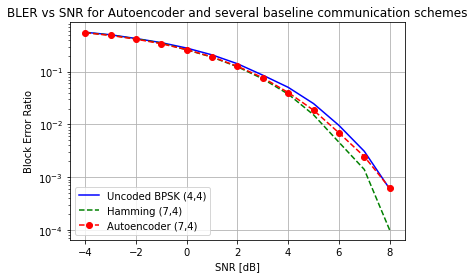

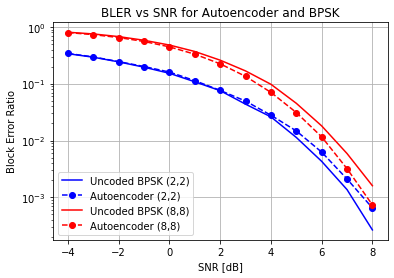

In [77]:
# File:   radio_autoencoder.py
# Brief:  Simulates a radio link over AWGN channel for Uncoded, Hamming 
#         coded and Neural network autoencoded radio links.
#         Reproduces the results obtained in 
#         "An Introduction to Deep Learning for the Physical Layer",
#         Timothy J. O'Shea, Jakob Hoydis
# Author: Vidit Saxena
#
# Usage:  python radio_autoencoder.py
#
# -------------------------------------------------------------------------
#
# Copyright (C) 2016 CC0 1.0 Universal (CC0 1.0) 
#
# The person who associated a work with this deed has dedicated the work to
# the public domain by waiving all of his or her rights to the work 
# worldwide under copyright law, including all related and neighboring 
# rights, to the extent allowed by law.
#
# You can copy, modify, distribute and perform the work, even for commercial 
# purposes, all without asking permission.
#
# See the complete legal text at 
# <https://creativecommons.org/publicdomain/zero/1.0/legalcode>
#
# -------------------------------------------------------------------------

#from src import uncoded, hamming
#from src import autoencoder

from matplotlib import pyplot as plt

''' Function:    _bler_vs_snr_hamming_autoenc(block_size, channel_use, snrs_db)
    Description: Block error ratio (BLER) vs Signal to Noise Ratio (SNR) 
                 curves for standard channel coding using Hamming codes, 
                 and for 'learnt' optimal representation that are obtained 
                 by training a neural network based autoencoder. Additive 
                 White Gaussian Noise (AWGN) channel is assumed. 
'''  
def _bler_vs_snr_hamming_autoenc(block_size, channel_use, snrs_db):
    
    channel_use = {4: 7} # Mapping to get length of Hamming codeblock from block length 
        
    '''BLER for uncoded BPSK over AWGN channel'''
    print('-------Evaluating BLER for Uncoded (%d,%d) over AWGN-------'%(block_size, block_size))
    bler_unc = [block_error_ratio_uncoded_awgn(snr, block_size) for snr in snrs_db]
     
    '''BLER for Hamming coded bits over AWGN channel'''
    print('-------Evaluating BLER for Hamming (%d,%d) over AWGN-------' %(channel_use[block_size], block_size))
    bler_hamming = [block_error_ratio_hamming_awgn(snr, block_size) for snr in snrs_db]
    
    '''BLER for Autoencoder coded bits over AWGN channel'''
    print('-------Evaluating BLER for Autoencoder (%d,%d) over AWGN-------' %(channel_use[block_size], block_size))
    batch_size = int(20/block_size)
    nrof_steps = int(200000/block_size)
    bler_autoenc = block_error_ratio_autoencoder_awgn(snrs_db, block_size, channel_use[block_size], batch_size, nrof_steps)
    
    print('-------Plotting results-------')
    plt.figure()
    plt.grid(True)
    plt.semilogy(snrs_db, bler_unc, ls = '-', c = 'b')
    plt.semilogy(snrs_db, bler_hamming, ls = '--', c = 'g')
    plt.semilogy(snrs_db, bler_autoenc, ls = '--', c = 'r', marker = 'o')
    plt.xlabel('SNR [dB]')
    plt.ylabel('Block Error Ratio')
    plt.legend(['Uncoded BPSK (%d,%d)'%(block_size, block_size), 
                'Hamming (%d,%d)'%(channel_use[block_size], block_size),
                'Autoencoder (%d,%d)'%(channel_use[block_size], block_size)],
               loc = 'lower left')
    plt.title('BLER vs SNR for Autoencoder and several baseline communication schemes')
    
    print (bler_unc)
    print(bler_hamming)
    print (bler_autoenc)
    return (bler_hamming, bler_autoenc)

''' Function:    _bler_vs_snr_hamming_autoenc(block_size, channel_use, snrs_db)
    Description: Block error ratio (BLER) vs Signal to Noise Ratio (SNR) curves 
                 for uncoded transmission, and for 'learnt' optimal 
                 representations of the transmitted bits that are obtained by 
                 training a neural network based autoencoder. Additive White 
                 Gaussian Noise (AWGN) channel is assumed. 
'''  
def _bler_vs_snr_uncoded_autoenc(block_sizes, snrs_db):
    
    plt.figure()
    plt.grid(True)
    legend_strings = []
    colors = iter(list(['b', 'r', 'g', 'b', 'm']))
    for block_size in block_sizes:
        '''BLER for uncoded bits over AWGN channel'''
        print('-------Evaluating BLER for Uncoded BPSK (%d,%d) over AWGN-------' %(block_size, block_size))
        bler_unc = [block_error_ratio_uncoded_awgn(snr, block_size) for snr in snrs_db]
    
        '''BLER for Autoencoder coded  bits over AWGN channel'''
        print('-------Evaluating BLER for Autoencoder (%d,%d) over AWGN-------' %(block_size, block_size))
        batch_size = 10/block_size
        nrof_steps = 100000/block_size
        bler_autoenc = block_error_ratio_autoencoder_awgn(snrs_db, block_size, block_size, batch_size, nrof_steps)
        
        print('-------Plotting results-------')
        color = next(colors) 
        plt.semilogy(snrs_db, bler_unc, ls = '-', c = color)
        plt.semilogy(snrs_db, bler_autoenc, ls = '--', c = color, marker = 'o')
        
        legend_strings.append('Uncoded BPSK (%d,%d)'%(block_size, block_size))
        legend_strings.append('Autoencoder (%d,%d)'%(block_size, block_size))

    plt.xlabel('SNR [dB]')
    plt.ylabel('Block Error Ratio')
    plt.legend(legend_strings, loc = 'lower left')
    plt.title('BLER vs SNR for Autoencoder and BPSK')
    
if __name__ == '__main__':
    snrs_db = range(-4, 9)
    
    '''BLER for block size 4 with Autoencoder and Hamming'''
    block_size = 4
    channel_use = 7
    _bler_vs_snr_hamming_autoenc(block_size, channel_use, snrs_db)

    '''BLER for block sizes 2 and 8 with uncoded and Autoencoder'''
    block_sizes = [2, 8]
    _bler_vs_snr_uncoded_autoenc(block_sizes, snrs_db)
    
    plt.show()

In [78]:
print ("bpsk")
print(ber_itpp_uncoded_bpsk)
print(ber_per_iter_uncoded_itpp_bpsk)
print(ber_per_iter_ham_itpp_bpsk)
print(ber_per_iter_ldpc_itpp_bpsk)

print ("psk-2")
print(ber_itpp_uncoded_bpsk_c)
print(ber_itpp_uncoded_psk_2)
print(ber_per_iter_uncoded_itpp_psk_2)
print(ber_per_iter_uncoded_50_itpp_psk_2)
print(ber_per_iter_uncoded_100_itpp_psk_2)
print(ber_per_iter_uncoded_commpy_psk_2)
print(ber_per_iter_uncoded_50_commpy_psk_2)
print(ber_per_iter_uncoded_100_commpy_psk_2)
print(ber_per_iter_ham_itpp_psk_2)
print(ber_per_iter_ham_50_itpp_psk_2)
print(ber_per_iter_ldpc_itpp_psk_2)

print ("psk-4")
print(ber_itpp_uncoded_psk_4)
print(ber_per_iter_uncoded_itpp_psk_4)
print(ber_per_iter_uncoded_50_itpp_psk_4)
print(ber_per_iter_uncoded_100_itpp_psk_4)
print(ber_per_iter_uncoded_commpy_psk_4)
print(ber_per_iter_uncoded_50_commpy_psk_4)
print(ber_per_iter_uncoded_100_commpy_psk_4)
print(ber_per_iter_ham_itpp_psk_4)
print(ber_per_iter_ham_50_itpp_psk_4)
print(ber_per_iter_ldpc_50_100_itpp_psk_4)
print(ber_per_iter_ldpc_itpp_psk_4)

print ("psk-8")
print(ber_itpp_uncoded_psk_8)
print(ber_per_iter_uncoded_itpp_psk_8)
print(ber_per_iter_uncoded_commpy_psk_8)


bpsk
[0.15892333333333333, 0.14329, 0.13157333333333332, 0.11666666666666667, 0.10406666666666667, 0.09071, 0.07874333333333333, 0.06747333333333333, 0.05697666666666667, 0.046283333333333336, 0.0376, 0.03008, 0.022746666666666665, 0.01733, 0.012663333333333334, 0.009146666666666668, 0.006063333333333333, 0.003926666666666667, 0.002436666666666667, 0.0015033333333333333, 0.0007633333333333333, 0.0003733333333333333, 0.00017, 0.00010666666666666667, 5e-05, 3.3333333333333333e-06, 3.3333333333333333e-06, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.15777778 0.13966667 0.12955556 0.11833333 0.10722222 0.08844444
 0.08277778 0.06888889 0.05388889 0.045      0.03611111 0.03033333
 0.02188889 0.018      0.01377778 0.00955556 0.00622222 0.00411111
 0.00166667 0.00177778]
[0.143375 0.10575  0.10325  0.091    0.073375 0.0595   0.044    0.03375
 0.025625 0.01675  0.01275  0.

In [79]:
print ("bpsk")
print(bler_per_iter_uncoded_itpp_bpsk)
print(bler_per_iter_ham_itpp_bpsk)
print(bler_per_iter_ldpc_itpp_bpsk)

print("")
print ("psk-2")
print(bler_per_iter_uncoded_itpp_psk_2)
print(bler_per_iter_uncoded_50_itpp_psk_2)
print(bler_per_iter_uncoded_100_itpp_psk_2)
print(bler_per_iter_uncoded_commpy_psk_2)
print(bler_per_iter_uncoded_50_commpy_psk_2)
print(bler_per_iter_uncoded_100_commpy_psk_2)
print(bler_per_iter_ham_itpp_psk_2)
print(bler_per_iter_ham_50_itpp_psk_2)
print(bler_per_iter_ldpc_itpp_psk_2)


print("")
print ("psk-4")
print(bler_per_iter_uncoded_itpp_psk_4)
print(bler_per_iter_uncoded_50_itpp_psk_4)
print(bler_per_iter_uncoded_100_itpp_psk_4)
print(bler_per_iter_uncoded_commpy_psk_4)
print(bler_per_iter_uncoded_50_commpy_psk_4)
print(bler_per_iter_uncoded_100_commpy_psk_4)
print(bler_per_iter_ham_itpp_psk_4)
print(bler_per_iter_ham_50_itpp_psk_4)
print(bler_per_iter_ldpc_50_100_itpp_psk_4)
print(bler_per_iter_ldpc_itpp_psk_4)
print("")
print ("psk-8")
print(bler_per_iter_uncoded_itpp_psk_8)
print(bler_per_iter_uncoded_commpy_psk_8)


bpsk
[0.774 0.769 0.731 0.678 0.636 0.559 0.551 0.466 0.405 0.327 0.291 0.239
 0.183 0.145 0.121 0.085 0.055 0.037 0.015 0.016]
[0.537 0.402 0.397 0.362 0.293 0.239 0.18  0.149 0.12  0.074 0.056 0.034
 0.016 0.014 0.006 0.003 0.003 0.001 0.    0.   ]
[0.643 0.553 0.455 0.347 0.305 0.217 0.14  0.1   0.069 0.042 0.02  0.008
 0.003 0.003 0.002 0.003 0.    0.    0.    0.   ]

psk-2
[0.518 0.478 0.415 0.355 0.305 0.227 0.177 0.149 0.11  0.075 0.055 0.023
 0.014 0.014 0.015 0.001 0.003 0.001 0.    0.   ]
[0.978 0.964 0.941 0.908 0.85  0.753 0.697 0.59  0.484 0.36  0.276 0.178
 0.115 0.064 0.047 0.019 0.006 0.002 0.001 0.   ]
[0.999 0.999 0.997 0.992 0.976 0.945 0.904 0.824 0.703 0.609 0.429 0.329
 0.225 0.131 0.079 0.042 0.013 0.005 0.003 0.   ]
[0.51  0.471 0.407 0.373 0.317 0.244 0.192 0.155 0.115 0.079 0.05  0.033
 0.025 0.006 0.007 0.002 0.004 0.001 0.    0.   ]
[0.979 0.959 0.941 0.888 0.858 0.774 0.698 0.579 0.488 0.323 0.259 0.201
 0.108 0.065 0.027 0.022 0.008 0.007 0.005 0.001]
[1. 